# Run

## Imports

In [ ]:
! pip install mplfinance

In [ ]:
# Ставим зависимости
!apt-get install -y build-essential
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib-0.4.0/
!./configure --prefix=/usr
!make
!make install
%cd ..
# Устанавливаем python-обертку
!pip install Ta-Lib
import talib

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.
--2025-09-30 11:35:38--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 104.18.12.149, 104.18.13.149, 2606:4700::6812:d95, ...
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|104.18.12.149|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2025-09-30 11:35:39--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 104.18.13.149, 104.18.12.149, 2606:4700::6812:d95, ...
Reusing existing connection to prdownloads.sourceforge.n

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import talib
import random
import datetime
import time
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

## Funcrions

### Get Binance klines

In [ ]:
from datetime import timezone, datetime
import os
import requests
import zipfile
import csv
import io
from dateutil.relativedelta import relativedelta

def generate_months(start_date, end_date):
    start_date = datetime.strptime(start_date, '%Y-%m')
    end_date = datetime.strptime(end_date, '%Y-%m')
    months = []

    while start_date <= end_date:
        months.append(start_date.strftime('%Y-%m'))
        start_date = start_date + relativedelta(months=1)

    return months


# Загрузка данных с Binance
def download_klines(symbol, interval, start_date, end_date):
    months = generate_months(start_date, end_date)
    if not os.path.exists('klines'):
        os.mkdir('klines')

    klines = {
        'Date': [], 'Open': [], 'High': [], 'Low': [], 'Close': [], 'Volume': []
    }

    for month in months:
        filename = f"{symbol}-{interval}-{month}.zip"
        file_path = f"klines/{filename}"

        if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
            url = f"https://data.binance.vision/data/futures/um/monthly/klines/{symbol}/{interval}/{filename}"
            try:
                r = requests.get(url, allow_redirects=True)
                with open(file_path, 'wb') as f:
                    f.write(r.content)
            except Exception as e:
                print(f"Ошибка загрузки файла {filename}: {e}. Пропускаем.")
                continue

        try:
            with zipfile.ZipFile(file_path, 'r') as zip_file:
                with zip_file.open(f"{symbol}-{interval}-{month}.csv", 'r') as csv_file:
                    csv_reader = csv.reader(io.TextIOWrapper(csv_file, 'utf-8'))
                    for row in csv_reader:
                        if row[0].isdigit():
                            klines['Date'].append(datetime.fromtimestamp(int(row[0]) / 1000, tz=timezone.utc))
                            klines['Open'].append(float(row[1]))
                            klines['High'].append(float(row[2]))
                            klines['Low'].append(float(row[3]))
                            klines['Close'].append(float(row[4]))
                            klines['Volume'].append(float(row[5]))
        except (zipfile.BadZipFile, KeyError):
            print(f"Ошибка: Файл {file_path} поврежден или не является ZIP. Пропускаем.")
            continue


    if not klines['Date']:
        raise ValueError(f"Нет доступных данных для {symbol} в диапазоне {start_date} - {end_date}")

    df = pd.DataFrame(klines)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    return df

### Candle patterns

In [ ]:
import numpy as np
import pandas as pd

def detect_candlestick_patterns(
    df,
    doji_th=0.1,
    hammer_lower_mult=2.0,
    hammer_upper_mult=0.3,
    small_body_factor=0.5,
    min_body_pct=0.2
):
    df = df.copy()
    o = df['open'].astype(float)
    h = df['high'].astype(float)
    l = df['low'].astype(float)
    c = df['close'].astype(float)

    prev_o = o.shift(1); prev_h = h.shift(1); prev_l = l.shift(1); prev_c = c.shift(1)
    pre_prev_o = o.shift(2); pre_prev_c = c.shift(2)

    # --- Базовые величины ---
    df['body'] = c - o
    df['body_abs'] = df['body'].abs()
    df['range'] = (h - l).replace(0, np.nan)
    df['upper_shadow'] = h - np.maximum(o, c)
    df['lower_shadow'] = np.minimum(o, c) - l
    df['body_pct_of_range'] = df['body_abs'] / df['range']

    # --- Doji ---
    df['doji'] = (df['range'].isna() & (df['body_abs'] == 0)) | \
                 (df['body_abs'] <= doji_th * df['range'])

    # --- Hammer (бычий сигнал) ---
    df['hammer'] = (
        (df['lower_shadow'] >= hammer_lower_mult * df['body_abs']) &
        (df['upper_shadow'] <= hammer_upper_mult * df['body_abs']) &
        (df['body_pct_of_range'] <= 0.5)
    )

    # --- Inverted Hammer ---
    df['inverted_hammer'] = (
        (df['upper_shadow'] >= hammer_lower_mult * df['body_abs']) &
        (df['lower_shadow'] <= hammer_upper_mult * df['body_abs']) &
        (df['body_pct_of_range'] <= 0.5)
    )

    # --- Bullish Engulfing ---
    prev_body_abs = (prev_c - prev_o).abs()
    df['bullish_engulfing'] = (
        (prev_c < prev_o) & (c > o) & (o < prev_c) & (c > prev_o) &
        (df['body_abs'] > prev_body_abs)
    ).fillna(False)

    # --- Bearish Engulfing ---
    df['bearish_engulfing'] = (
        (prev_c > prev_o) & (c < o) & (o > prev_c) & (c < prev_o) &
        (df['body_abs'] > prev_body_abs)
    ).fillna(False)

    # --- Piercing Line (бычий) ---
    df['piercing_line'] = (
        (prev_c < prev_o) & (o < prev_c) & (c > (prev_o + prev_c) / 2)
    ).fillna(False)

    # --- Dark Cloud Cover (медвежий) ---
    df['dark_cloud'] = (
        (prev_c > prev_o) & (o > prev_h) & (c < (prev_o + prev_c) / 2) & (c > prev_o)
    ).fillna(False)

    # --- Morning Star (бычий, 3 свечи) ---
    prev_body_abs = (prev_c - prev_o).abs()
    pre_prev_body_abs = (pre_prev_c - pre_prev_o).abs()
    df['morning_star'] = (
        (pre_prev_c < pre_prev_o) &
        (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
        (c > o) & (c > (pre_prev_o + pre_prev_c) / 2)
    ).fillna(False)

    # --- Evening Star (медвежий, 3 свечи) ---
    df['evening_star'] = (
        (pre_prev_c > pre_prev_o) &
        (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
        (c < o) & (c < (pre_prev_o + pre_prev_c) / 2)
    ).fillna(False)

    # --- Three White Soldiers ---
    o0, o1, o2 = o.shift(2), o.shift(1), o
    c0, c1, c2 = c.shift(2), c.shift(1), c
    df['three_white_soldiers'] = (
        (c0 > o0) & (c1 > o1) & (c2 > o2) &
        (c2 > c1) & (c1 > c0) &
        (o1 > o0) & (o2 > o1)
    ).fillna(False)

    # --- Three Black Crows (медвежий аналог) ---
    df['three_black_crows'] = (
        (c0 < o0) & (c1 < o1) & (c2 < o2) &
        (c2 < c1) & (c1 < c0) &
        (o1 < o0) & (o2 < o1)
    ).fillna(False)

    # --- Harami Cross ---
    prev_body_top = np.maximum(prev_o, prev_c)
    prev_body_bottom = np.minimum(prev_o, prev_c)
    harami_cross = (
        df['doji'] & (h < prev_body_top) & (l > prev_body_bottom) &
        (prev_body_abs >= (min_body_pct * df['range'].shift(1)))
    )
    df['harami_cross'] = harami_cross.fillna(False)

    # --- Bearish Harami ---
    df['bearish_harami'] = (
        (prev_c > prev_o) & (c < o) &
        (h < prev_c) & (l > prev_o)
    ).fillna(False)

    # Очистка вспомогательных колонок
    df = df.drop(columns=[
        'body','body_abs','range','upper_shadow','lower_shadow','body_pct_of_range'
    ])

    return df


In [ ]:
# import numpy as np
# import pandas as pd

# def detect_candlestick_patterns(df,
#                                 doji_th=0.1,               # doji: тело <= 10% от range
#                                 hammer_lower_mult=2.0,     # lower_shadow >= 2 * body
#                                 hammer_upper_mult=0.3,     # upper_shadow <= 0.3 * body
#                                 small_body_factor=0.5,     # middle candle size relative threshold for morning star
#                                 min_body_pct=0.2):         # minimum body size relative to candle range for "strong" bodies
#     # ASSUME df has numeric columns: 'open','high','low','close'
#     df = df.copy()

#     o = df['open'].astype(float)
#     h = df['high'].astype(float)
#     l = df['low'].astype(float)
#     c = df['close'].astype(float)

#     prev_o = o.shift(1)
#     prev_h = h.shift(1)
#     prev_l = l.shift(1)
#     prev_c = c.shift(1)

#     pre_prev_o = o.shift(2)
#     pre_prev_c = c.shift(2)

#     # basic measures
#     df['body'] = c - o
#     df['body_abs'] = df['body'].abs()
#     df['range'] = (h - l).replace(0, np.nan)   # avoid div by zero, keep NaN for zero-range
#     df['upper_shadow'] = h - np.maximum(o, c)
#     df['lower_shadow'] = np.minimum(o, c) - l
#     df['body_pct_of_range'] = df['body_abs'] / df['range']

#     # DOJI (relative to candle range)
#     df['doji'] = (df['range'].isna() & (df['body_abs'] == 0)) | (df['body_abs'] <= doji_th * df['range'])

#     # HAMMER (both bullish or bearish allowed)
#     hammer_cond = (
#         (df['lower_shadow'] >= hammer_lower_mult * df['body_abs']) &
#         (df['upper_shadow'] <= hammer_upper_mult * df['body_abs']) &
#         (df['body_pct_of_range'] <= 0.5)   # body not too large relative to range
#     )
#     df['hammer'] = hammer_cond

#     # INVERTED HAMMER
#     inv_hammer_cond = (
#         (df['upper_shadow'] >= hammer_lower_mult * df['body_abs']) &
#         (df['lower_shadow'] <= hammer_upper_mult * df['body_abs']) &
#         (df['body_pct_of_range'] <= 0.5)
#     )
#     df['inverted_hammer'] = inv_hammer_cond

#     # BULLISH ENGULFING
#     prev_body_abs = (prev_c - prev_o).abs()
#     bull_engulf = (
#         (prev_c < prev_o) &           # previous bearish
#         (c > o) &                     # current bullish
#         (o < prev_c) &                # current open below previous close (i.e. below previous body top)
#         (c > prev_o) &                # current close above previous open (engulf)
#         (df['body_abs'] > prev_body_abs)  # optional: current body bigger than previous
#     )
#     df['bullish_engulfing'] = bull_engulf.fillna(False)

#     # PIERCING LINE (classic definition)
#     piercing = (
#         (prev_c < prev_o) &  # prev bearish
#         (o < prev_l) &       # current open below previous low (gap down) -- can relax to prev_c if desired
#         (c > (prev_o + prev_c) / 2)  # close into upper half of previous body
#     )
#     df['piercing_line'] = piercing.fillna(False)

#     # MORNING STAR (3-candle pattern)
#     # 1) pre_prev bearish
#     # 2) previous small body relative to pre_prev
#     # 3) current bullish and closes above midpoint of pre_prev body
#     prev_body_abs = (prev_c - prev_o).abs()
#     pre_prev_body_abs = (pre_prev_c - pre_prev_o).abs()
#     morning_star = (
#         (pre_prev_c < pre_prev_o) &
#         (prev_body_abs <= small_body_factor * pre_prev_body_abs) &
#         (c > o) &
#         (o < prev_c) &  # current opens below previous close (gap or inside)
#         (c > (pre_prev_o + pre_prev_c) / 2)
#     )
#     df['morning_star'] = morning_star.fillna(False)

#     # THREE WHITE SOLDIERS (vectorized)
#     o0 = o.shift(2); o1 = o.shift(1); o2 = o
#     c0 = c.shift(2); c1 = c.shift(1); c2 = c
#     body0 = (c0 - o0).abs(); body1 = (c1 - o1).abs(); body2 = (c2 - o2).abs()
#     three_ws = (
#         (c0 > o0) & (c1 > o1) & (c2 > o2) &               # all bullish
#         (c2 > c1) & (c1 > c0) &                            # ascending closes
#         (o1 > o0) & (o2 > o1) &                            # opens move upward
#         (body0 >= min_body_pct * (h.shift(2) - l.shift(2)).replace(0, np.nan)) &
#         (body1 >= min_body_pct * (h.shift(1) - l.shift(1)).replace(0, np.nan)) &
#         (body2 >= min_body_pct * (h - l).replace(0, np.nan)) &
#         (o1 < c0) & (o2 < c1)                              # opens within previous bodies (not strict gap)
#     )
#     df['three_white_soldiers'] = three_ws.fillna(False)

#     # HARAMI CROSS (doji inside previous real body) — generalized both directions
#     prev_body_top = np.maximum(prev_o, prev_c)
#     prev_body_bottom = np.minimum(prev_o, prev_c)
#     harami_cross = (
#         df['doji'] &
#         (df['high'] < prev_body_top) &
#         (df['low'] > prev_body_bottom) &
#         (prev_body_abs >= (min_body_pct * df['range'].shift(1)))  # prev body not tiny
#     )
#     df['harami_cross'] = harami_cross.fillna(False)

#     # clean helper columns if you like
#     df = df.drop(columns=['body','body_abs','range','upper_shadow','lower_shadow','body_pct_of_range'])
#     return df


In [ ]:
# # functions for calculating patterns
# import pandas as pd

# def is_doji(row, threshold=0.1):
#     return abs(row['open'] - row['close']) <= threshold

# def is_hammer(row):
#     body = abs(row['open'] - row['close'])
#     lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
#     upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
#     return lower_shadow > 2 * body and upper_shadow < body

# def is_bullish_engulfing(current_row, previous_row):
#     return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
#            current_row['open'] < previous_row['close'] and current_row['close'] > previous_row['open']

# def is_piercing_line(current_row, previous_row):
#     return previous_row['close'] < previous_row['open'] and current_row['close'] > current_row['open'] and \
#             current_row['open'] < previous_row['low'] and current_row['close'] > (previous_row['open'] + previous_row['close']) / 2

# def is_morning_star(current_row, previous_row, pre_previous_row):
#     return pre_previous_row['close'] < pre_previous_row['open'] and \
#           abs(previous_row['close'] - previous_row['open']) < abs(pre_previous_row['close'] - pre_previous_row['open']) / 2 and \
#           current_row['close'] > current_row['open'] and \
#           current_row['open'] < previous_row['close'] and \
#           current_row['close'] > (previous_row['close'] + previous_row['open']) / 2

# def is_inverted_hammer(row):
#     body = abs(row['open'] - row['close'])
#     upper_shadow = row['high'] - row['close'] if row['open'] <  row['close'] else row['high'] - row['open']
#     lower_shadow = row['open'] - row['low'] if row['open'] <  row['close'] else row['close'] - row['low']
#     return upper_shadow > 2 * body and lower_shadow < body

# def is_three_white_soldiers(df, idx):
#     if idx < 2:
#         return False
#     current = df.iloc[idx]
#     prev1 = df.iloc[idx - 1]
#     prev2 = df.iloc[idx - 2]
#     return all([current['close'] > current['open'], prev1['close'] > prev1['open'], prev2['close'] > prev2['open']]) and \
#            all([current['open'] > prev1['close'], prev1['open'] > prev2['close']]) and \
#            all([current['close'] > prev1['close'], prev1['close'] > prev2['close']])

# def is_harami_cross(current_row, previous_row):
#     return abs(current_row['open'] - current_row['close']) < (current_row['high'] - current_row['low']) * 0.1 and \
#            previous_row['open'] > previous_row['close'] and current_row['high'] < previous_row['open' ] and current_row['low'] > previous_row['close']

# data['doji'] = data.apply(is_doji, axis=1)
# data['hammer'] = data.apply(is_hammer, axis=1)
# data['bull_engulfing'] = data.apply(lambda row: is_bullish_engulfing(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
# data['piercing_line'] = data.apply(lambda row: is_piercing_line(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)
# data['morning_star'] = data.apply(lambda row: is_morning_star(row, data.iloc[data.index.get_loc(row.name) - 1], data.iloc[data.index.get_loc(row.name) - 2]) if data.index.get_loc(row.name) > 1 else False, axis=1)
# data['inverted_hammer'] = data.apply(is_inverted_hammer, axis=1)
# data['three_white_soldiers'] = data.apply(lambda row: is_three_white_soldiers(data, data.index.get_loc(row.name)), axis=1)
# data['harami_cross'] = data.apply(lambda row: is_harami_cross(row, data.iloc[data.index.get_loc(row.name) - 1]) if data.index.get_loc(row.name) > 0 else False, axis=1)

In [ ]:
from ast import pattern
# Function for analyzing candlestick patterns

def plot_random_pattern(data, pattern_column, pattern_name):
    patterns = data[data[pattern_column] != 0]

    if patterns.empty:
      print(f"No occurences of {pattern_name} pattern found.")
      return

    random_index = random.choice(patterns.index)
    start_index = max(0, data.index.get_loc(random_index) - 20)
    end_index = min(len(data), data.index.get_loc(random_index) + 20)

    data_window = data.iloc[start_index:end_index+1]

    fig, axlist = mpf.plot(data_window, type='candle', style='nightclouds', volume=True,
                          title=f'{pattern_name} Pattern Detection at {random_index.date()}',
                          show_nontrading=True, returnfig=True, figsize=(12,6))

    axes = axlist[0]
    pattern_row = data.loc[random_index]

    # Add a short line to a candlestick plot
    axes.annotate('', xy=(random_index, pattern_row['high']),
                  xytext=(random_index, pattern_row['high'] + 0.15), # set the line size
                  arrowprops=dict(facecolor='magenta', edgecolor='magenta', arrowstyle='->', lw=1.5))

    axes.text(random_index, pattern_row['high'] + 0.2, pattern_name,
              horizontalalignment='center', verticalalignment='bottom', fontsize=10, color='magenta')


### Stationarity

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def adf_test(series, p_threshold=0.05):
    """Проверка стационарности ряда через ADF-тест"""
    series = series.dropna()
    if series.nunique() < 2:  # слишком мало уникальных значений
        return False
    try:
        result = adfuller(series)
        p_value = result[1]
        t_test = result[0] < result[4]["5%"]
        return p_value < p_threshold and t_test
    except Exception:
        return False



def make_stationary(data, p_threshold=0.05):
    """
    Проверяет все признаки на стационарность и приводит нестационарные к стационарному виду.
    data - DataFrame с фичами
    """
    df = data.copy()
    non_stationaries = []

    # 1. Проверяем исходные признаки
    for col in df.columns:
        col_data = df[col].replace([np.inf, -np.inf], np.nan).dropna()
        if len(col_data) > 10 and not adf_test(col_data, p_threshold=p_threshold):
            non_stationaries.append(col)

    print(f"Нестационарные признаки: {len(non_stationaries)}")

    # 2. Пробуем разные трансформации
    for col in non_stationaries:
        transformed = None
        col_data = df[col].replace([np.inf, -np.inf], np.nan)

        # Попробуем log (только для положительных)
        if (col_data > 0).all():
            log_series = np.log(col_data)
            if adf_test(log_series, p_threshold):
                transformed = log_series
            else:
                # log + diff
                log_diff = np.log(col_data).diff()
                if adf_test(log_diff.dropna(), p_threshold):
                    transformed = log_diff

        # Если log не помог → diff
        if transformed is None:
            diff_series = col_data.diff()
            if adf_test(diff_series.dropna(), p_threshold):
                transformed = diff_series

        # Если ничего не сработало → просто diff
        if transformed is None:
            transformed = col_data.diff()

        df[col] = transformed

    # 3. Удаляем первые NaN после разностей
    df = df.dropna()

    return df

In [ ]:
# from statsmodels.tsa.stattools import adfuller
# import numpy as np

# non_stationaries = []

# for col in df_stationary.columns:
#     # Replace infinite values with NaN and drop NaN values for the current column
#     col_data = df_stationary[col].replace([np.inf, -np.inf], np.nan).dropna()

#     if col_data.nunique() > 1:  # Проверка на различные значения в столбце
#         # Ensure there are enough data points after dropping NaNs for the test
#         if len(col_data) > 0:
#             try:
#                 dftest = adfuller(col_data.values)
#                 p_value = dftest[1]
#                 # Check if the test statistic is less than the 1% critical value
#                 t_test = dftest[0] < dftest[4]["1%"]
#                 if p_value > 0.05 or not t_test:
#                     non_stationaries.append(col)
#             except ValueError:
#                  # Handle cases where adfuller might still fail (e.g., not enough variation)
#                  print(f"Could not perform ADF test on column {col}")

# print(f"Non-Stationary Features Found: {len(non_stationaries)}")

### EDA

In [ ]:
# Function for detecting outliers in a dataframe
# Displays boxplots and a table with outlier information

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def detect_outliers(dataframe):
    outlier_table = pd.DataFrame(columns=['Column', 'Outlier Count', 'Outlier Percentage'])  # Creating a DataFrame to store outlier information

    for column in dataframe.columns:
        if dataframe[column].dtype != 'object' and len(dataframe[column].unique()) == 2:  # Checking for columns with binary values
            print(f"No outliers in column '{column}' as it has binary values.")  # Printing a message indicating binary values
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': ['NaN'],
                                       'Outlier Percentage': ['NaN']})],
                                       ignore_index=True)  # Updating the outlier table with binary value information
            print('*' * 75)
            print()
            continue  # Skipping to the next iteration if the column has binary values

        # skipping the object type
        if dataframe[column].dtype == 'object':
            break

        q1 = dataframe[column].quantile(0.25)  # Calculating the first quartile
        q3 = dataframe[column].quantile(0.75)  # Calculating the third quartile
        iqr = q3 - q1  # Calculating the interquartile range
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Counting the number of outliers
        outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
        num_outliers = len(outliers)
        column_len = len(dataframe[column])

        if num_outliers == 0:
            print(f"No outliers in column '{column}'.")
            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                                    'Outlier Count': [0],
                                                    'Outlier Percentage': [0]})],
                                                    ignore_index=True)  # Updating the outlier table with outlier count
        else:
            print(f"Outliers in column '{column}':")
            print(f"Outlier Count: {num_outliers}")
            print(f"Outlier Percentage of total observations: {(num_outliers / column_len) * 100:.2f}%")  # Calculating and displaying outlier percentage
            print("Outlier Values:", ", ".join(outliers[column].astype(str)))

            outlier_table = pd.concat([outlier_table,
                                       pd.DataFrame({'Column': [column],
                                       'Outlier Count': [num_outliers],
                                       'Outlier Percentage': [(num_outliers / column_len) * 100]})],
                                       ignore_index=True)  # Updating the outlier table with outlier information

            # Plotting the boxplot with outliers
            fig, ax = plt.subplots(figsize=(8, 6))
            sns.boxplot(data=dataframe, x=column, ax=ax)
            ax.set_title(f"Outlier Plot for column '{column}'")
            plt.show()

        print('*' * 75)
        print()

    display(outlier_table)

In [ ]:
# Correlation analysis on a dataframe with a target feature using some specified correlation types

!pip install phik
from phik import phik_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def correlation_analysis(dataframe, target_feature, correlation_types=['phik'], apply_abs=False):
    target_column = dataframe[target_feature] # Target feature
    correlation_data = [] # List to store correlations
    interval_cols = [col for col in dataframe.columns if col != target_feature] # Set interval columns for phik

    # Calculate correlation coefficients with the target feature for each column and specified correlation types
    for column in dataframe.columns:
        if column != target_feature:
            for corr_type in correlation_types:
                corr_value = None

                if corr_type == 'pearson':
                    corr_value = stats.pearsonr(target_column, dataframe[column])[0]
                elif corr_type == 'spearman':
                    corr_value = stats.spearmanr(target_column, dataframe[column]).correlation
                elif corr_type == 'kendall':
                    corr_value = stats.kendalltau(target_column, dataframe[column]).correlation
                elif corr_type == 'phik':
                    corr_value = phik_matrix(dataframe, interval_cols=interval_cols)[target_feature][column]
                # Apply absolute value, if specified
                if corr_value is not None and apply_abs:
                  corr_value = abs(corr_value)
                correlation_data.append((column, corr_type, corr_value))

    correlation_df = pd.DataFrame(correlation_data, columns=['Column', 'Correlation Type', 'Correlation Value'])  # Create DataFrame
    correlation_df_sorted = correlation_df.pivot(index='Column', columns='Correlation Type', values='Correlation Value')
    correlation_df_sorted = correlation_df_sorted[correlation_types] # Keep only specified correlation types
    correlation_df_sorted = correlation_df_sorted.sort_values(by=correlation_types, ascending=False) # Sort the data by specified correlation types


    # Correlation plot
    fig, axes = plt.subplots(nrows=1, ncols=len(correlation_types), figsize=(8 * len(correlation_types), 6))

    for i, corr_type in enumerate(correlation_types):
        corr_with_target = correlation_df_sorted[corr_type]
        corr_with_target_sorted = corr_with_target.sort_values(ascending=True) # Sort the data

        # Set plot parameters
        sns.barplot(data=corr_with_target_sorted.reset_index(), x='Column', y=corr_type, ax=axes[i], color='dodgerblue')


        axes[i].set_xlabel('Features')
        axes[i].set_ylabel('Correlation')
        axes[i].set_title(corr_type)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=75)
    plt.tight_layout(pad=1)
    plt.show()


    # Top 2 features with the highest correlation for each specified correlation type
    top_columns = {}
    for corr_type in correlation_types:
        sorted_columns = correlation_df_sorted[corr_type].abs().sort_values(ascending=False)
        top_columns[corr_type] = sorted_columns.index[:2].tolist()

    # Display correlation table
    print(f"Correlation table with target feature '{target_feature}':")
    display(correlation_df_sorted)

    # Display the top 2 features with the highest correlation for each correlation type
    for corr_type in correlation_types:
        print()
        print(f"Top 2 features with highest correlation ({corr_type.capitalize()}):", top_columns[corr_type])

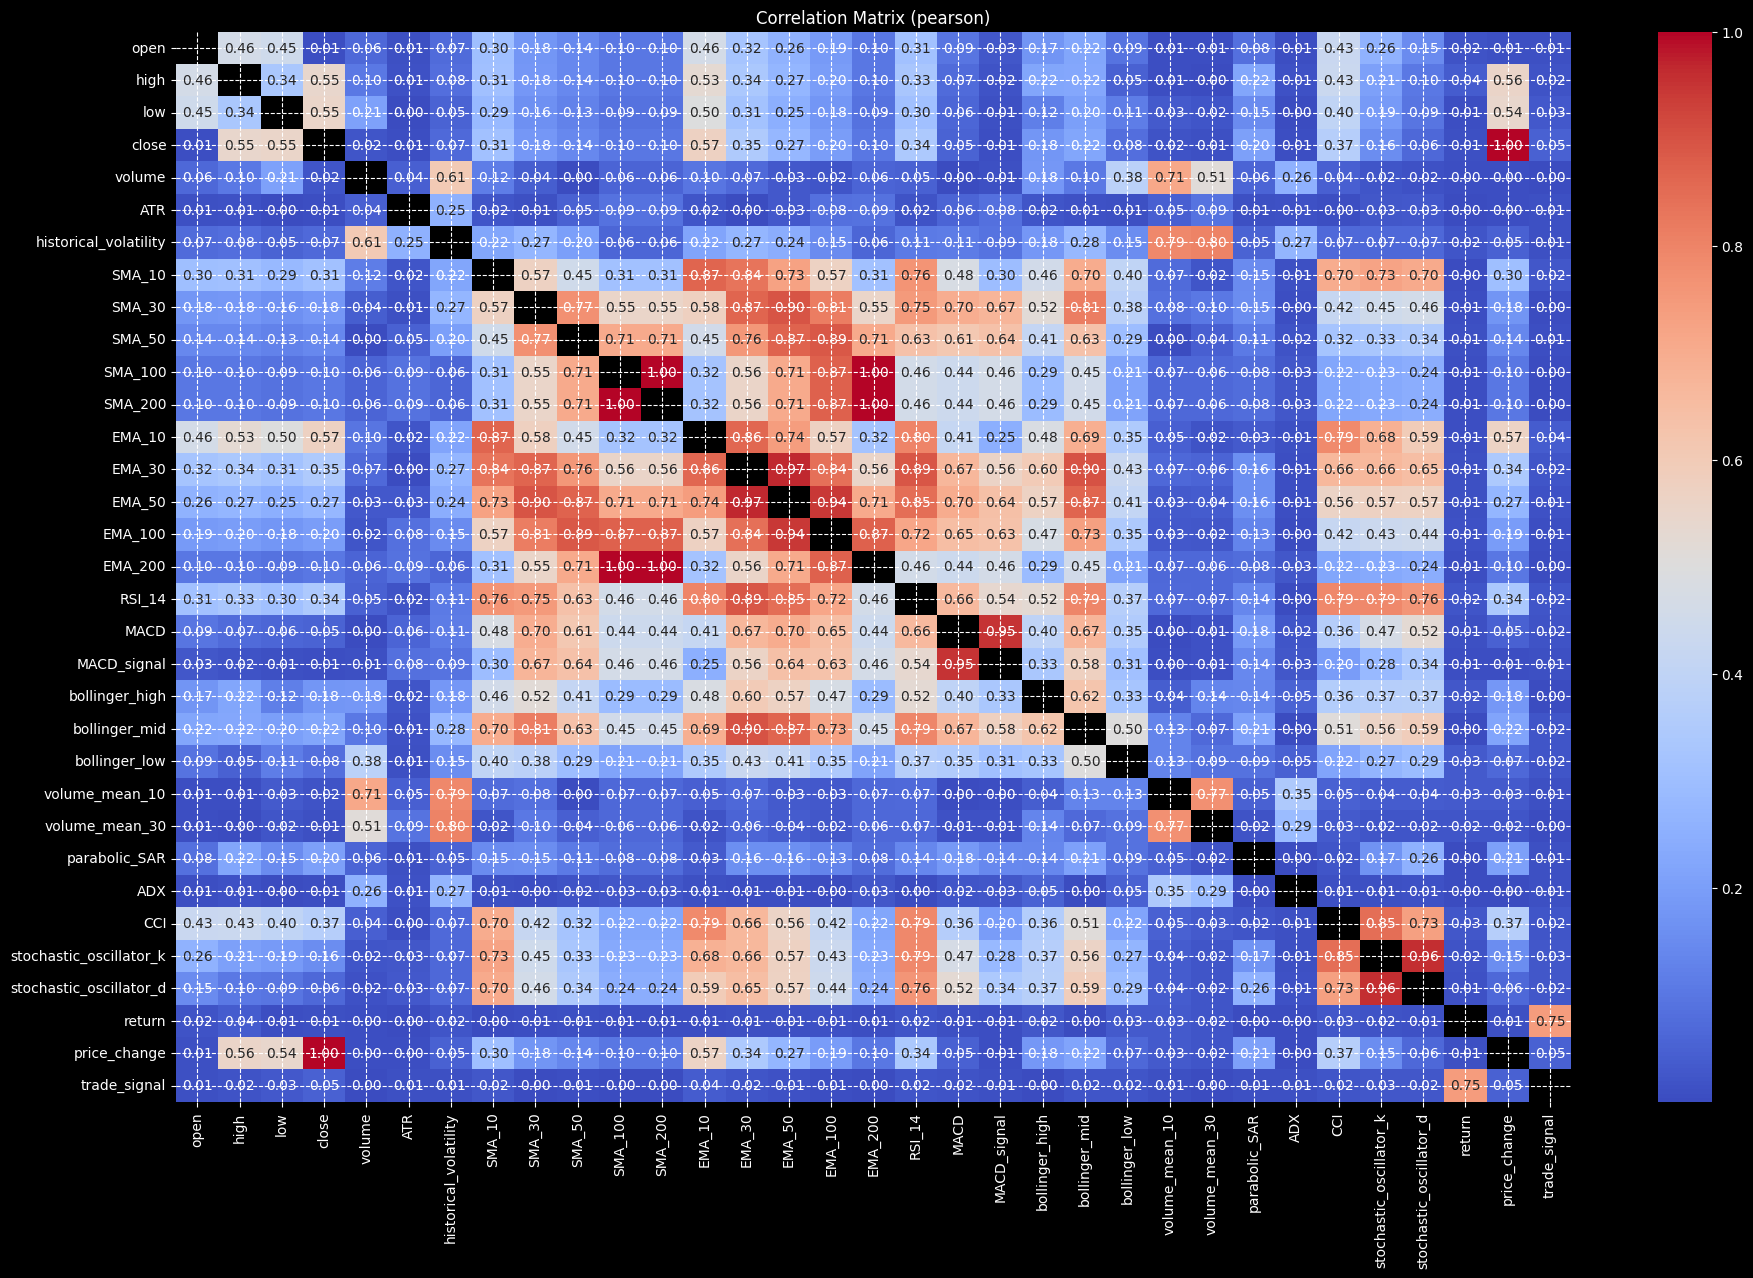


Multicollinearity Table (pearson)


Feature 1                Feature 2  Correlation
1                  SMA_100                  SMA_200     1.000000
3                  SMA_200                  EMA_200     1.000000
2                  SMA_100                  EMA_200     1.000000
0                    close             price_change     0.999052
4                   EMA_30                   EMA_50     0.967883
8  stochastic_oscillator_k  stochastic_oscillator_d     0.958114
7                     MACD              MACD_signal     0.952103
6                   EMA_50                  EMA_100     0.942733
5                   EMA_30            bollinger_mid     0.900324

In [ ]:
# Function to find multicollinearity and print correlation matrix
# !pip install phik
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from phik import phik_matrix

def find_multicollinearity(dataframe, methods=['phik'], threshold=0.8):
    # List to store all multicollinear tables
    multicollinear_tables = []

    # Iterate through each method in the list of methods
    for method in methods:
        # Convert method to lowercase
        method = method.lower()

        # Calculate correlation matrix using specified sort method
        if method in ['pearson', 'kendall', 'spearman']:
            corr_matrix = dataframe.corr(method=method).abs()
        elif method == 'phik':
            interval_cols = [col for col in dataframe.columns]
            corr_matrix = phik_matrix(dataframe, interval_cols=interval_cols)
        else:
            print(f"Invalid method: {method}")
            continue

        # Exclude correlation of a variable with itself
        np.fill_diagonal(corr_matrix.values, np.NaN)

        # Create a larger figure size based on the number of features
        n = corr_matrix.shape[0]
        fig_width = 6 + n * 0.5
        fig_height = 4 + n * 0.3

        # Plot correlation matrix as heatmap with adjusted figure size
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", mask=np.isnan(corr_matrix))
        plt.title(f"Correlation Matrix ({method})")
        plt.show()

        # Initialize an empty list to store multicollinear features
        multicollinear_table = []

        # Iterate through each pair of multicollinear features and their correlation percentages
        for i in range(n):
            for j in range(i+1, n):
                # Check if the correlation between the two features is above the threshold
                if corr_matrix.iloc[i, j] > threshold:
                    feature1 = corr_matrix.columns[i]
                    feature2 = corr_matrix.columns[j]
                    # Append the pair of multicollinear features and their correlation percentage to the list
                    multicollinear_table.append({'Feature 1': feature1, 'Feature 2': feature2, 'Correlation': corr_matrix.iloc[i, j]})

        # Create a dataframe from the list of multicollinear features
        multicollinear_table = pd.DataFrame(multicollinear_table)

        if not multicollinear_table.empty:
            # Sort the multicollinear table by correlation in descending order
            multicollinear_table = multicollinear_table.sort_values(by='Correlation', ascending=False)
            # Append the multicollinear table to the list of multicollinear tables
            multicollinear_tables.append((method, multicollinear_table))

    # Print all multicollinear tables
    if multicollinear_tables:
        for method, table in multicollinear_tables:
            print(f"\nMulticollinearity Table ({method})")
            display(table)
    else:
        print("\nNo features with high multicollinearity!")

find_multicollinearity(df_stationary, methods=['pearson'], threshold=0.9)

## Data extraction

In [ ]:
# Data extraction
symbol = 'SOLUSDT'
interval = '15m'
start_date = '2022-09'
end_date = '2025-08'

data_klines = download_klines(symbol, interval, start_date, end_date)
data = data_klines.copy()

In [ ]:
# check and remove duplicates in index
data = data[~data.index.duplicated(keep='first')]

In [ ]:
data

Open    High     Low   Close     Volume
Date                                                                
2022-09-01 00:00:00+00:00   31.47   31.74   31.40   31.67  374808.00
2022-09-01 00:15:00+00:00   31.67   31.75   31.57   31.64  202094.00
2022-09-01 00:30:00+00:00   31.64   31.68   31.11   31.12  340600.00
2022-09-01 00:45:00+00:00   31.12   31.52   31.10   31.46  383609.00
2022-09-01 01:00:00+00:00   31.45   31.58   31.34   31.34  258541.00
...                           ...     ...     ...     ...        ...
2025-08-31 22:45:00+00:00  203.76  204.11  203.30  203.64  253050.63
2025-08-31 23:00:00+00:00  203.65  203.82  203.04  203.40  258766.38
2025-08-31 23:15:00+00:00  203.41  203.41  202.24  202.35  363684.74
2025-08-31 23:30:00+00:00  202.36  202.38  200.51  200.60  773470.32
2025-08-31 23:45:00+00:00  200.60  201.11  200.20  200.57  383655.13

[105216 rows x 5 columns]

In [ ]:
data.columns = data.columns.str.lower()
data.head()

open   high    low  close    volume
Date                                                           
2022-09-01 00:00:00+00:00  31.47  31.74  31.40  31.67  374808.0
2022-09-01 00:15:00+00:00  31.67  31.75  31.57  31.64  202094.0
2022-09-01 00:30:00+00:00  31.64  31.68  31.11  31.12  340600.0
2022-09-01 00:45:00+00:00  31.12  31.52  31.10  31.46  383609.0
2022-09-01 01:00:00+00:00  31.45  31.58  31.34  31.34  258541.0

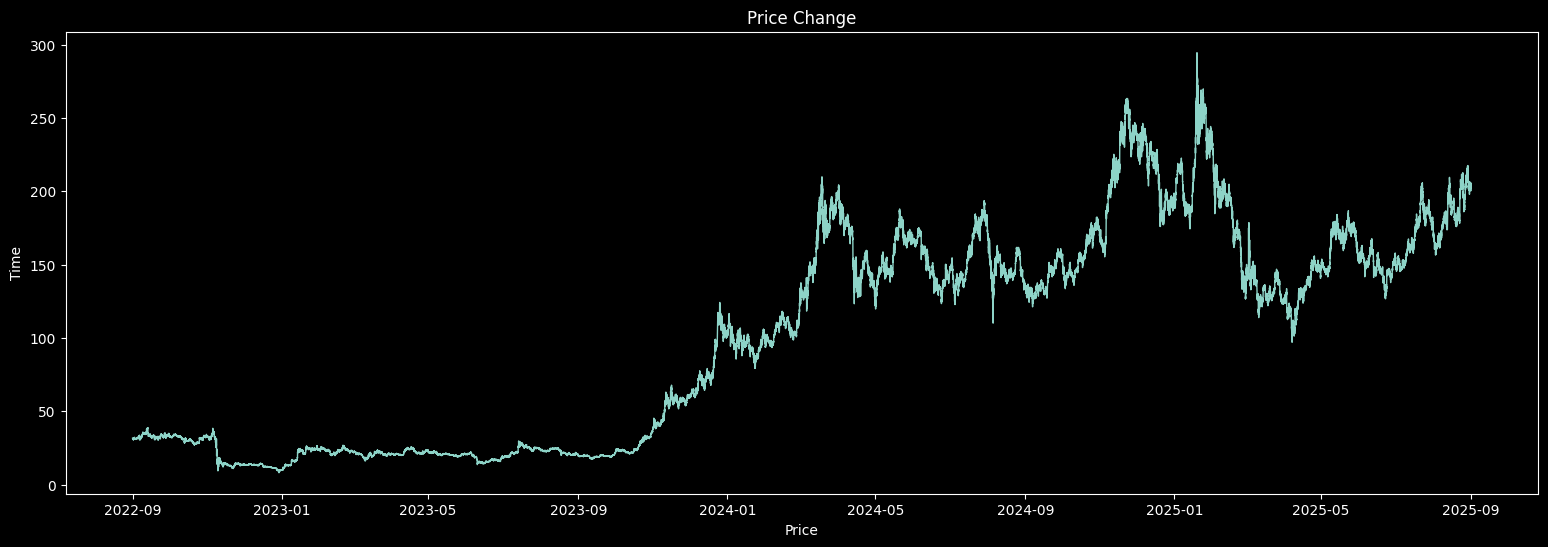

In [ ]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(19,6))
plt.plot(data.index, data['close'])
plt.xlabel('Price')
plt.ylabel('Time')
plt.title('Price Change')
plt.grid()
plt.show()


## Candle patterns

In [ ]:
data = detect_candlestick_patterns(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105216 entries, 2022-09-01 00:00:00+00:00 to 2025-08-31 23:45:00+00:00
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   open                  105216 non-null  float64
 1   high                  105216 non-null  float64
 2   low                   105216 non-null  float64
 3   close                 105216 non-null  float64
 4   volume                105216 non-null  float64
 5   doji                  105216 non-null  bool   
 6   hammer                105216 non-null  bool   
 7   inverted_hammer       105216 non-null  bool   
 8   bullish_engulfing     105216 non-null  bool   
 9   bearish_engulfing     105216 non-null  bool   
 10  piercing_line         105216 non-null  bool   
 11  dark_cloud            105216 non-null  bool   
 12  morning_star          105216 non-null  bool   
 13  evening_star          105216 non-null  bool   
 14  three_

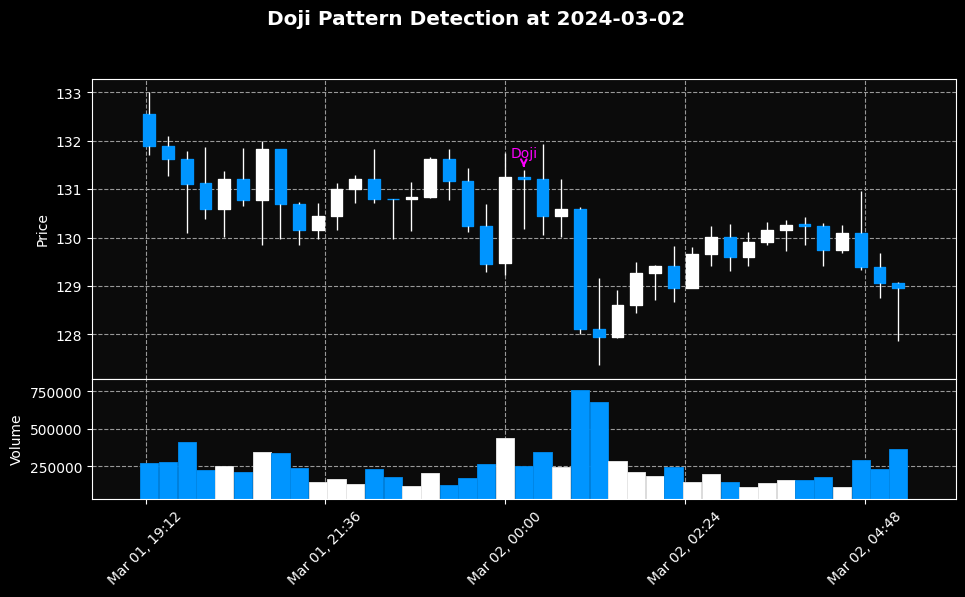

In [ ]:
plot_random_pattern(data, 'doji', 'Doji')

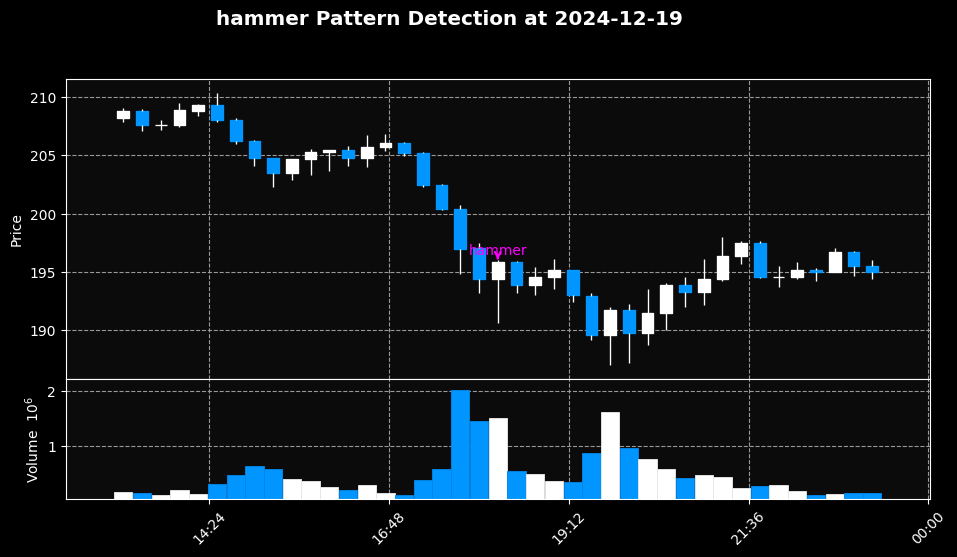

In [ ]:
# display a random pattern
plot_random_pattern(data, 'hammer', 'hammer')

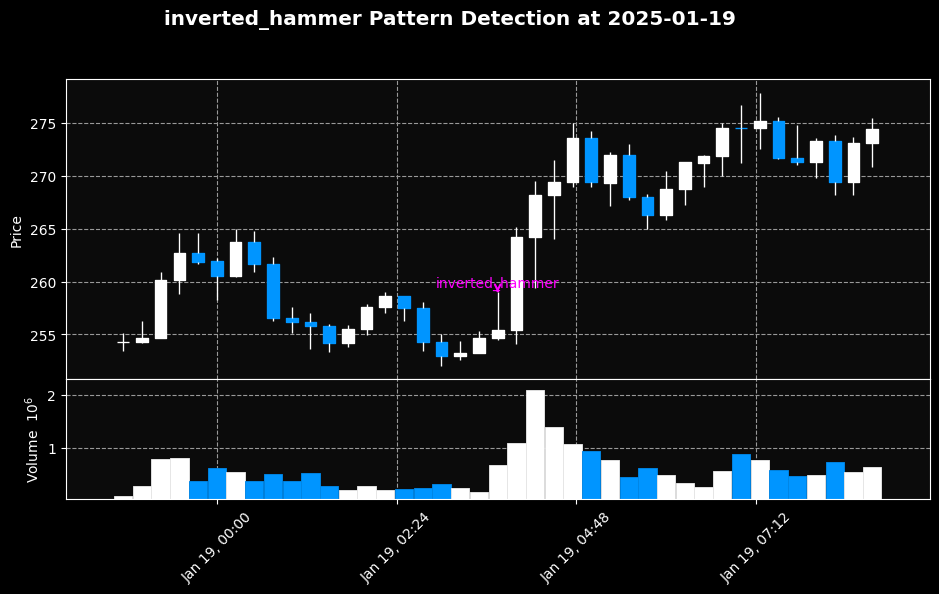

In [ ]:
plot_random_pattern(data, 'inverted_hammer', 'inverted_hammer')

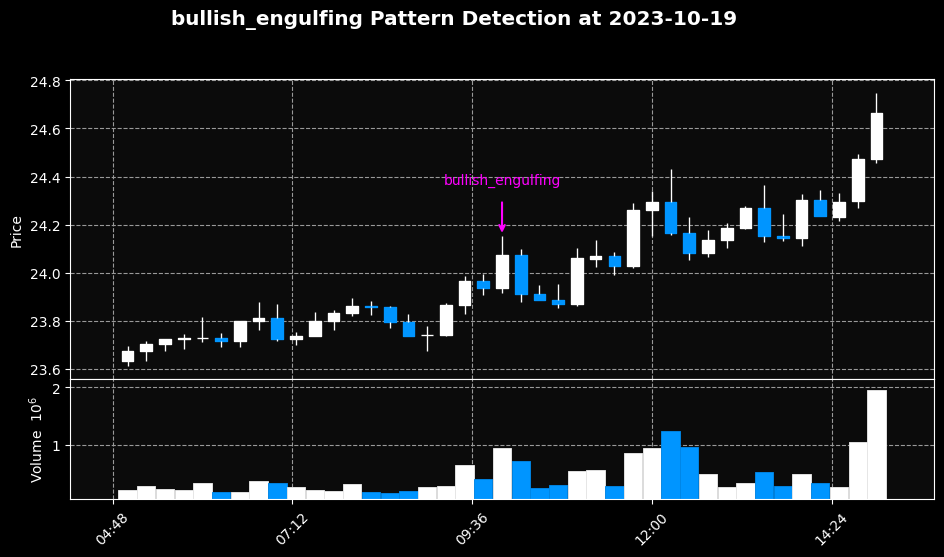

In [ ]:
plot_random_pattern(data, 'bullish_engulfing', 'bullish_engulfing')

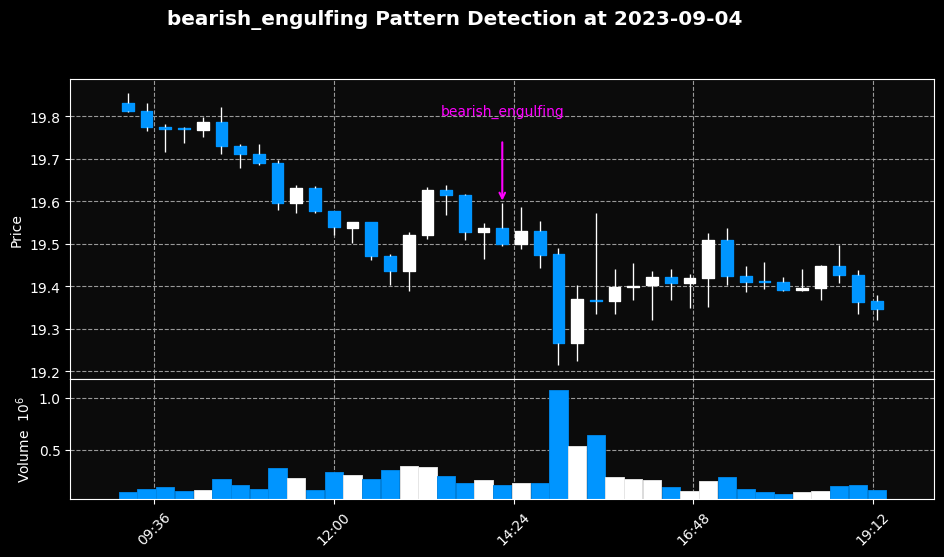

In [ ]:
plot_random_pattern(data, 'bearish_engulfing', 'bearish_engulfing')

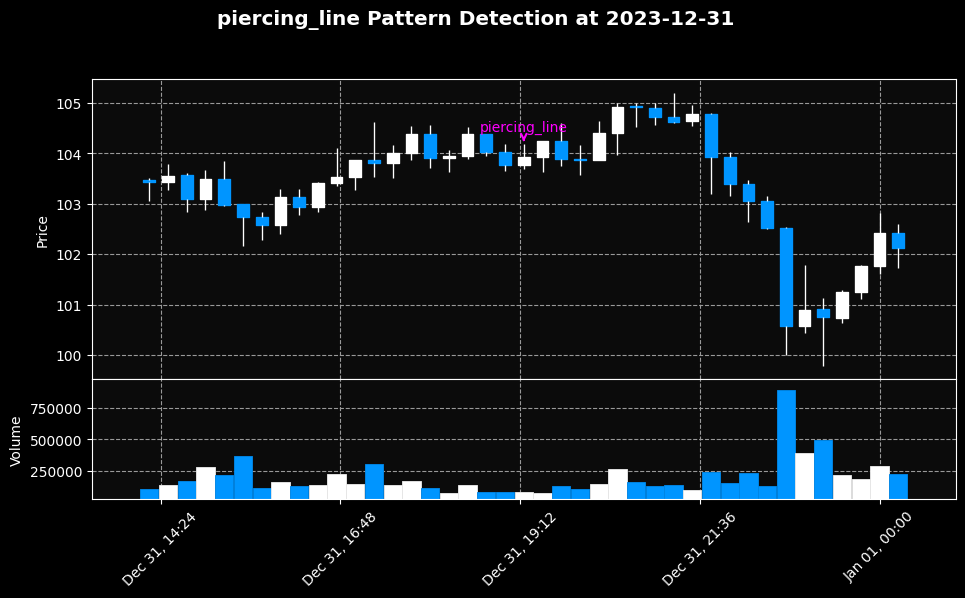

In [ ]:
plot_random_pattern(data, 'piercing_line', 'piercing_line')

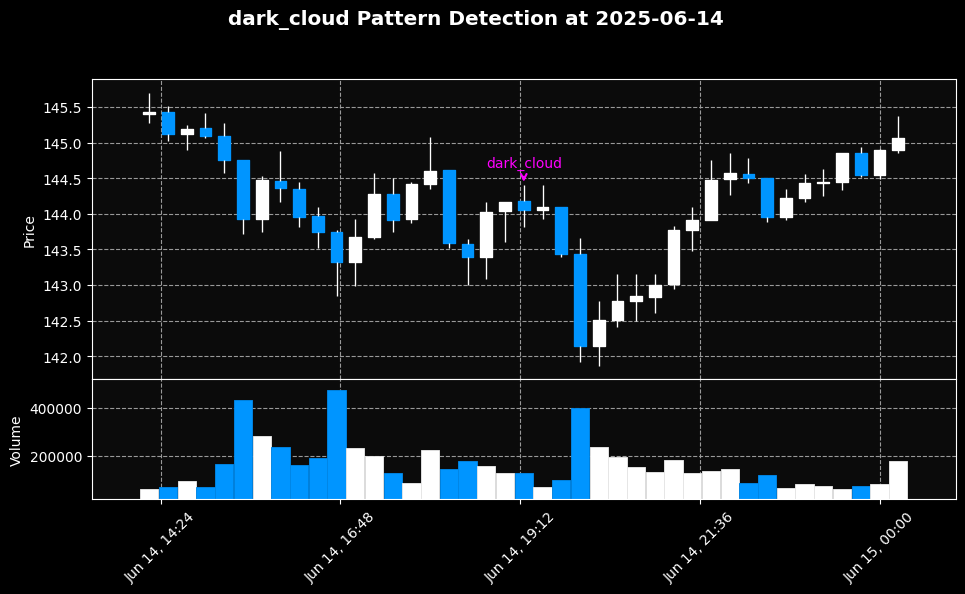

In [ ]:
plot_random_pattern(data, 'dark_cloud', 'dark_cloud')

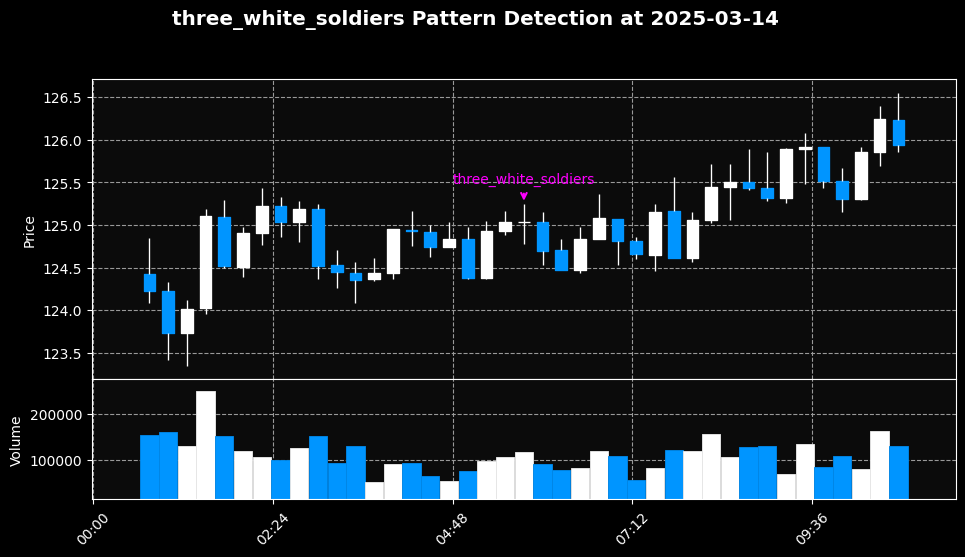

In [ ]:
plot_random_pattern(data, 'three_white_soldiers', 'three_white_soldiers')

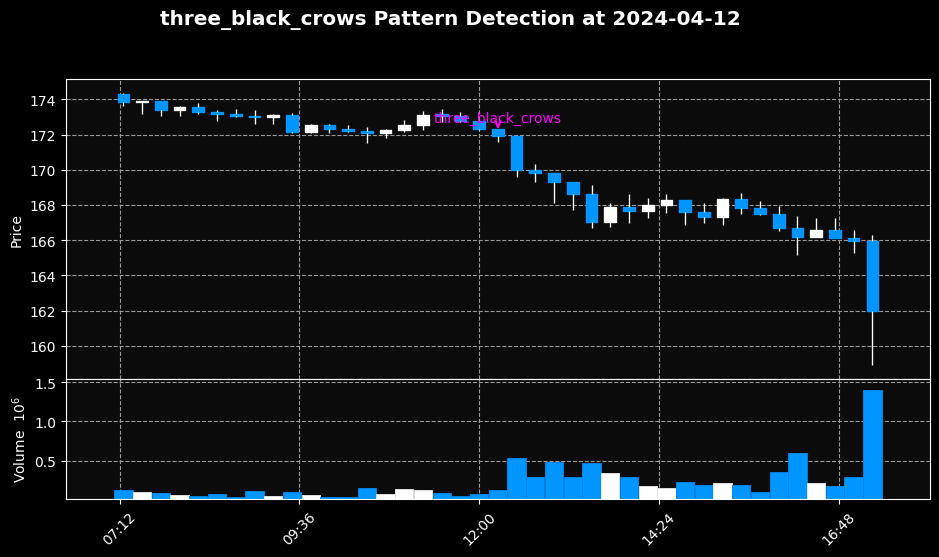

In [ ]:
plot_random_pattern(data, 'three_black_crows', 'three_black_crows')

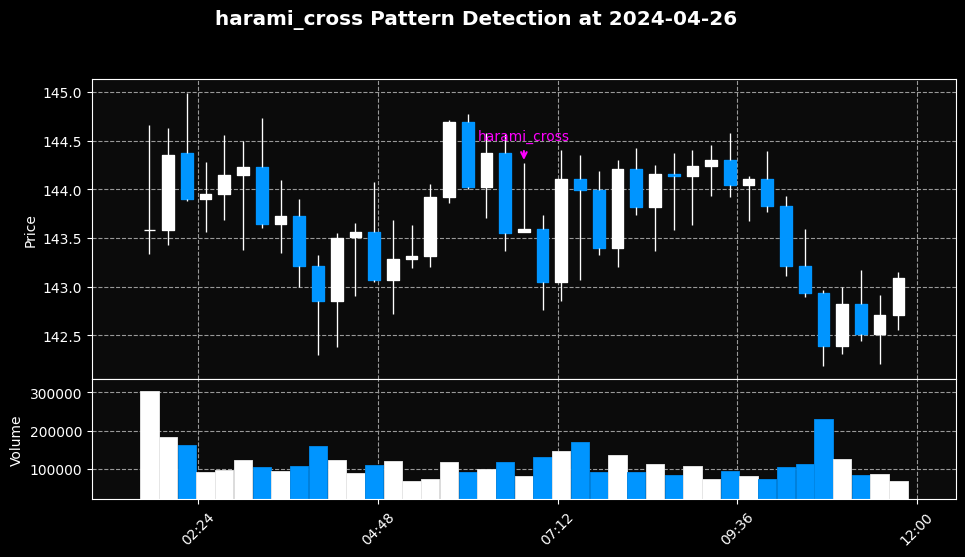

In [ ]:
plot_random_pattern(data, 'harami_cross', 'harami_cross')

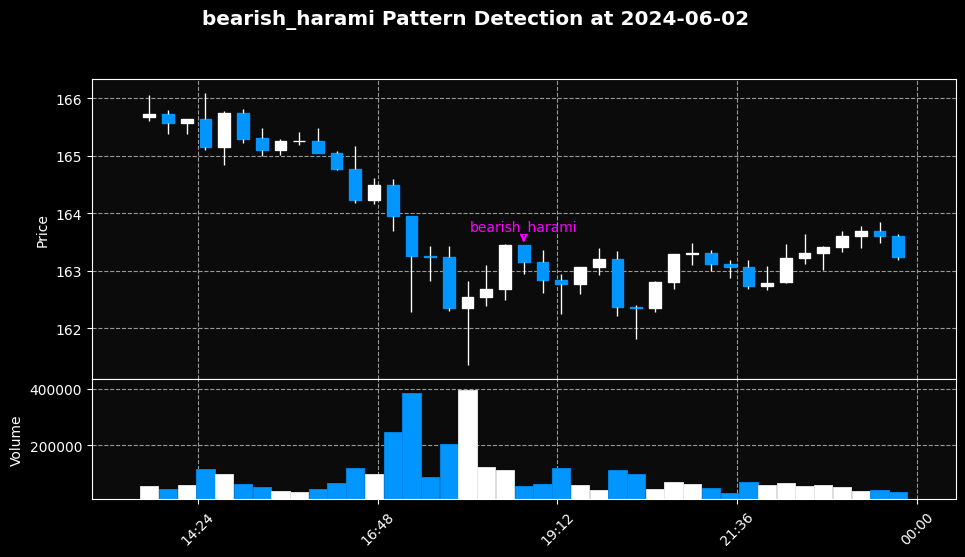

In [ ]:
plot_random_pattern(data, 'bearish_harami', 'bearish_harami')

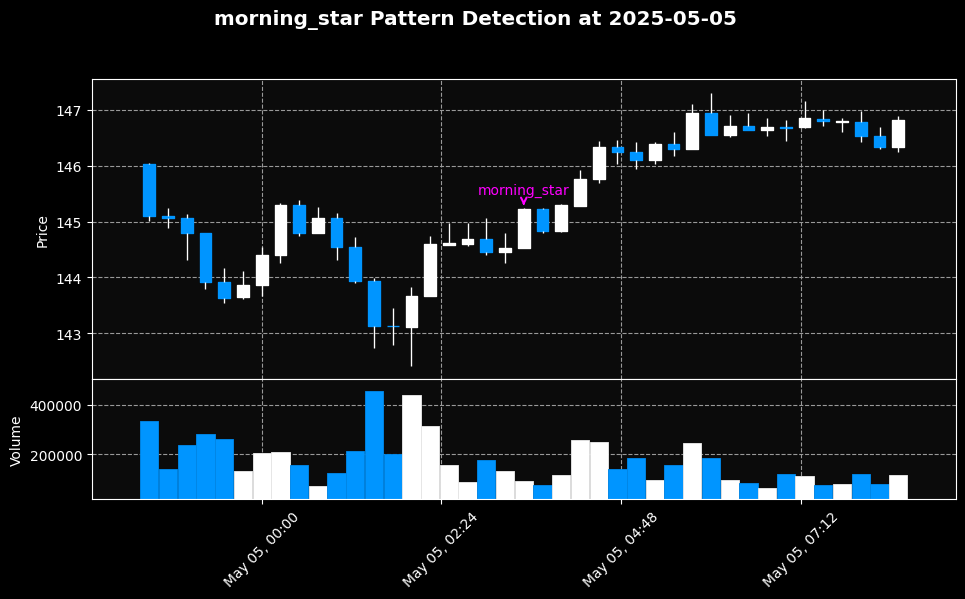

In [ ]:
plot_random_pattern(data, 'morning_star', 'morning_star')

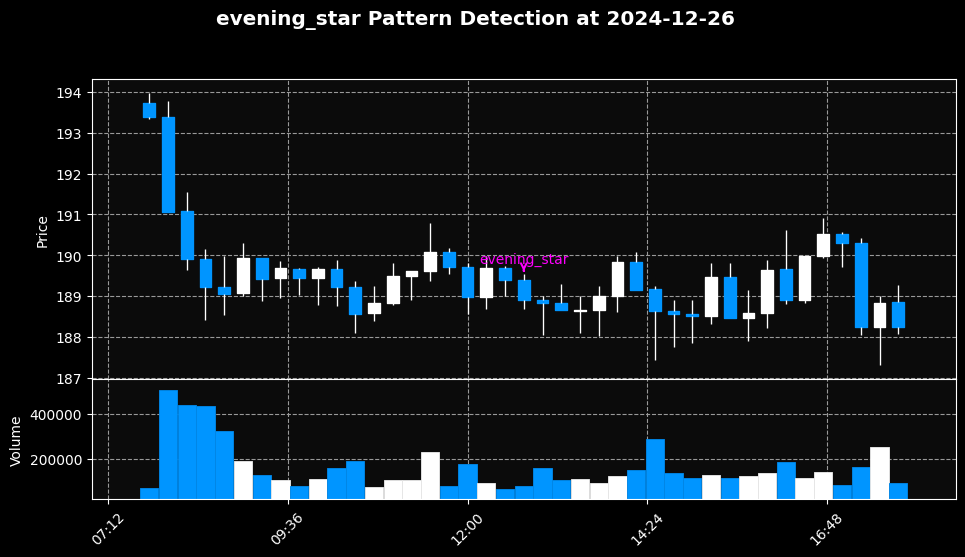

In [ ]:
plot_random_pattern(data, 'evening_star', 'evening_star')

Patterns count

In [ ]:
# Считаем количество True для всех свечных паттернов
pattern_cols = [
    "doji", "hammer", "inverted_hammer", "three_white_soldiers", "three_black_crows",
    "bullish_engulfing", "bearish_engulfing", "dark_cloud", "harami_cross",
    "morning_star", "evening_star", "piercing_line", "bearish_harami"
]

pattern_counts = {col: int(data[col].sum()) for col in pattern_cols}

# Печатаем статистику
for col, count in pattern_counts.items():
    print(f"{col.replace('_', ' ').title()} patterns: {count}")

print(f"\nTotal patterns: {sum(pattern_counts.values())}")

# Удаляем колонки, где нет ни одного сигнала
for col, count in pattern_counts.items():
    if count == 0:
        data.drop(columns=[col], inplace=True)


Doji patterns: 10204
Hammer patterns: 1959
Inverted Hammer patterns: 1706
Three White Soldiers patterns: 11334
Three Black Crows patterns: 11335
Bullish Engulfing patterns: 3478
Bearish Engulfing patterns: 3352
Dark Cloud patterns: 17
Harami Cross patterns: 2
Morning Star patterns: 4723
Evening Star patterns: 4822
Piercing Line patterns: 5084
Bearish Harami patterns: 57

Total patterns: 58073


## Indicators

In [ ]:
! pip install ta

In [ ]:
from ta import add_all_ta_features

In [ ]:
# data = add_all_ta_features(data, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105216 entries, 2022-09-01 00:00:00+00:00 to 2025-08-31 23:45:00+00:00
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   open                  105216 non-null  float64
 1   high                  105216 non-null  float64
 2   low                   105216 non-null  float64
 3   close                 105216 non-null  float64
 4   volume                105216 non-null  float64
 5   doji                  105216 non-null  bool   
 6   hammer                105216 non-null  bool   
 7   inverted_hammer       105216 non-null  bool   
 8   bullish_engulfing     105216 non-null  bool   
 9   bearish_engulfing     105216 non-null  bool   
 10  piercing_line         105216 non-null  bool   
 11  dark_cloud            105216 non-null  bool   
 12  morning_star          105216 non-null  bool   
 13  evening_star          105216 non-null  bool   
 14  three_

In [ ]:
# for col in df.columns:
#     print(col)

In [ ]:
data.head()

open   high    low  close    volume   doji  \
Date                                                                     
2022-09-01 00:00:00+00:00  31.47  31.74  31.40  31.67  374808.0  False   
2022-09-01 00:15:00+00:00  31.67  31.75  31.57  31.64  202094.0  False   
2022-09-01 00:30:00+00:00  31.64  31.68  31.11  31.12  340600.0  False   
2022-09-01 00:45:00+00:00  31.12  31.52  31.10  31.46  383609.0  False   
2022-09-01 01:00:00+00:00  31.45  31.58  31.34  31.34  258541.0  False   

                           hammer  inverted_hammer  bullish_engulfing  \
Date                                                                    
2022-09-01 00:00:00+00:00   False            False              False   
2022-09-01 00:15:00+00:00   False            False              False   
2022-09-01 00:30:00+00:00   False            False              False   
2022-09-01 00:45:00+00:00   False            False              False   
2022-09-01 01:00:00+00:00   False            False              False   

                           bearish_engulfing  piercing_line  dark_cloud  \
Date                                                                      
2022-09-01 00:00:00+00:00              False          False       False   
2022-09-01 00:15:00+00:00              False          False       False   
2022-09-01 00:30:00+00:00              False          False       False   
2022-09-01 00:45:00+00:00              False          False       False   
2022-09-01 01:00:00+00:00              False          False       False   

                           morning_star  evening_star  three_white_soldiers  \
Date                                                                          
2022-09-01 00:00:00+00:00         False         False                 False   
2022-09-01 00:15:00+00:00         False         False                 False   
2022-09-01 00:30:00+00:00         False          True                 False   
2022-09-01 00:45:00+00:00         False         False                 False   
2022-09-01 01:00:00+00:00         False         False                 False   

                           three_black_crows  harami_cross  bearish_harami  
Date                                                                        
2022-09-01 00:00:00+00:00              False         False           False  
2022-09-01 00:15:00+00:00              False         False           False  
2022-09-01 00:30:00+00:00              False         False           False  
2022-09-01 00:45:00+00:00              False         False           False  
2022-09-01 01:00:00+00:00              False         False           False

In [ ]:
# indecators culculations
data['ATR'] = talib.ATR(data['high'], data['low'], data['close'], timeperiod=14)
data['historical_volatility'] = talib.NATR(data['high'], data['low'], data['close'], timeperiod=14)
data['SMA_10'] = talib.SMA(data['close'], timeperiod=10)
data['SMA_30'] = talib.SMA(data['close'], timeperiod=30)
data['SMA_50'] = talib.SMA(data['close'], timeperiod=50)
data['SMA_100'] = talib.SMA(data['close'], timeperiod=100)
data['SMA_200'] = talib.SMA(data['close'], timeperiod=100)
data['EMA_10'] = talib.EMA(data['close'], timeperiod=10)
data['EMA_30'] = talib.EMA(data['close'], timeperiod=30)
data['EMA_50'] = talib.EMA(data['close'], timeperiod=50)
data['EMA_100'] = talib.EMA(data['close'], timeperiod=100)
data['EMA_200'] = talib.SMA(data['close'], timeperiod=100)
data['RSI_14'] = talib.RSI(data['close'], timeperiod=14)
data['MACD'], data['MACD_signal'], _ = talib.MACD(data['close'], fastperiod=12, slowperiod=26, signalperiod=9)
data['bollinger_high'], data['bollinger_mid'], data['bollinger_low'] = talib.BBANDS(data['close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
data['volume_mean_10'] = data['volume'].rolling(window=10).mean()
data['volume_mean_30'] = data['volume'].rolling(window=30).mean()
data['parabolic_SAR'] = talib.SAR(data['high'], data['low'], acceleration=0.02, maximum=0.2)
data['ADX'] = talib.ADX(data['high'], data['low'], data['close'], timeperiod=14)
data['CCI'] = talib.CCI(data['high'], data['low'], data['close'], timeperiod=14)
data['stochastic_oscillator_k'], data['stochastic_oscillator_d'] = talib.STOCH(data['high'], data['low'], data['close'],
                                                                               fastk_period=14, slowk_period=3, slowk_matype=0,
                                                                               slowd_period=3, slowd_matype=0)



# Removing rows with NaN values
data.dropna(inplace=True)
data

open    high     low   close     volume   doji  \
Date                                                                          
2022-09-02 00:45:00+00:00   31.31   31.49   31.30   31.44  108079.00  False   
2022-09-02 01:00:00+00:00   31.45   31.53   31.31   31.37  144724.00  False   
2022-09-02 01:15:00+00:00   31.36   31.50   31.35   31.46   78220.00  False   
2022-09-02 01:30:00+00:00   31.46   31.48   31.38   31.38   60667.00  False   
2022-09-02 01:45:00+00:00   31.38   31.40   31.30   31.38   82535.00   True   
...                           ...     ...     ...     ...        ...    ...   
2025-08-31 22:45:00+00:00  203.76  204.11  203.30  203.64  253050.63  False   
2025-08-31 23:00:00+00:00  203.65  203.82  203.04  203.40  258766.38  False   
2025-08-31 23:15:00+00:00  203.41  203.41  202.24  202.35  363684.74  False   
2025-08-31 23:30:00+00:00  202.36  202.38  200.51  200.60  773470.32  False   
2025-08-31 23:45:00+00:00  200.60  201.11  200.20  200.57  383655.13   True   

                           hammer  inverted_hammer  bullish_engulfing  \
Date                                                                    
2022-09-02 00:45:00+00:00   False            False              False   
2022-09-02 01:00:00+00:00   False            False              False   
2022-09-02 01:15:00+00:00   False            False               True   
2022-09-02 01:30:00+00:00   False            False              False   
2022-09-02 01:45:00+00:00   False            False              False   
...                           ...              ...                ...   
2025-08-31 22:45:00+00:00   False            False              False   
2025-08-31 23:00:00+00:00   False            False              False   
2025-08-31 23:15:00+00:00   False            False              False   
2025-08-31 23:30:00+00:00   False            False              False   
2025-08-31 23:45:00+00:00   False            False              False   

                           bearish_engulfing  ...  bollinger_high  \
Date                                          ...                   
2022-09-02 00:45:00+00:00              False  ...       31.677412   
2022-09-02 01:00:00+00:00              False  ...       31.658040   
2022-09-02 01:15:00+00:00              False  ...       31.654173   
2022-09-02 01:30:00+00:00              False  ...       31.636410   
2022-09-02 01:45:00+00:00              False  ...       31.636547   
...                                      ...  ...             ...   
2025-08-31 22:45:00+00:00              False  ...      205.719924   
2025-08-31 23:00:00+00:00              False  ...      205.809799   
2025-08-31 23:15:00+00:00              False  ...      206.077941   
2025-08-31 23:30:00+00:00              False  ...      206.621298   
2025-08-31 23:45:00+00:00              False  ...      206.838228   

                           bollinger_mid  bollinger_low  volume_mean_10  \
Date                                                                      
2022-09-02 00:45:00+00:00        31.4150      31.152588      119402.900   
2022-09-02 01:00:00+00:00        31.4265      31.194960      119283.600   
2022-09-02 01:15:00+00:00        31.4370      31.219827      118158.400   
2022-09-02 01:30:00+00:00        31.4460      31.255590      112752.100   
2022-09-02 01:45:00+00:00        31.4455      31.254453      111002.700   
...                                  ...            ...             ...   
2025-08-31 22:45:00+00:00       204.8020     203.884076      110377.079   
2025-08-31 23:00:00+00:00       204.7180     203.626201      131268.858   
2025-08-31 23:15:00+00:00       204.5855     203.093059      163366.805   
2025-08-31 23:30:00+00:00       204.3570     202.092702      233215.312   
2025-08-31 23:45:00+00:00       204.1075     201.376772      265878.738   

                           volume_mean_30  parabolic_SAR        ADX  \
Date                                                                  
2022-09-02 00:45:00+00:00   156379.

In [ ]:
data.head(3)

open   high    low  close    volume   doji  \
Date                                                                     
2022-09-02 00:45:00+00:00  31.31  31.49  31.30  31.44  108079.0  False   
2022-09-02 01:00:00+00:00  31.45  31.53  31.31  31.37  144724.0  False   
2022-09-02 01:15:00+00:00  31.36  31.50  31.35  31.46   78220.0  False   

                           hammer  inverted_hammer  bullish_engulfing  \
Date                                                                    
2022-09-02 00:45:00+00:00   False            False              False   
2022-09-02 01:00:00+00:00   False            False              False   
2022-09-02 01:15:00+00:00   False            False               True   

                           bearish_engulfing  ...  bollinger_high  \
Date                                          ...                   
2022-09-02 00:45:00+00:00              False  ...       31.677412   
2022-09-02 01:00:00+00:00              False  ...       31.658040   
2022-09-02 01:15:00+00:00              False  ...       31.654173   

                           bollinger_mid  bollinger_low  volume_mean_10  \
Date                                                                      
2022-09-02 00:45:00+00:00        31.4150      31.152588        119402.9   
2022-09-02 01:00:00+00:00        31.4265      31.194960        119283.6   
2022-09-02 01:15:00+00:00        31.4370      31.219827        118158.4   

                           volume_mean_30  parabolic_SAR        ADX  \
Date                                                                  
2022-09-02 00:45:00+00:00   156379.966667      31.702060  29.368711   
2022-09-02 01:00:00+00:00   151410.433333      31.685978  28.620355   
2022-09-02 01:15:00+00:00   148313.633333      31.670539  27.925454   

                                 CCI  stochastic_oscillator_k  \
Date                                                            
2022-09-02 00:45:00+00:00 -55.192308                26.143791   
2022-09-02 01:00:00+00:00 -69.549000                20.379085   
2022-09-02 01:15:00+00:00 -45.334797                28.222222   

                           stochastic_oscillator_d  
Date                                                
2022-09-02 00:45:00+00:00                39.741776  
2022-09-02 01:00:00+00:00                27.740741  
2022-09-02 01:15:00+00:00                24.915033  

[3 rows x 43 columns]

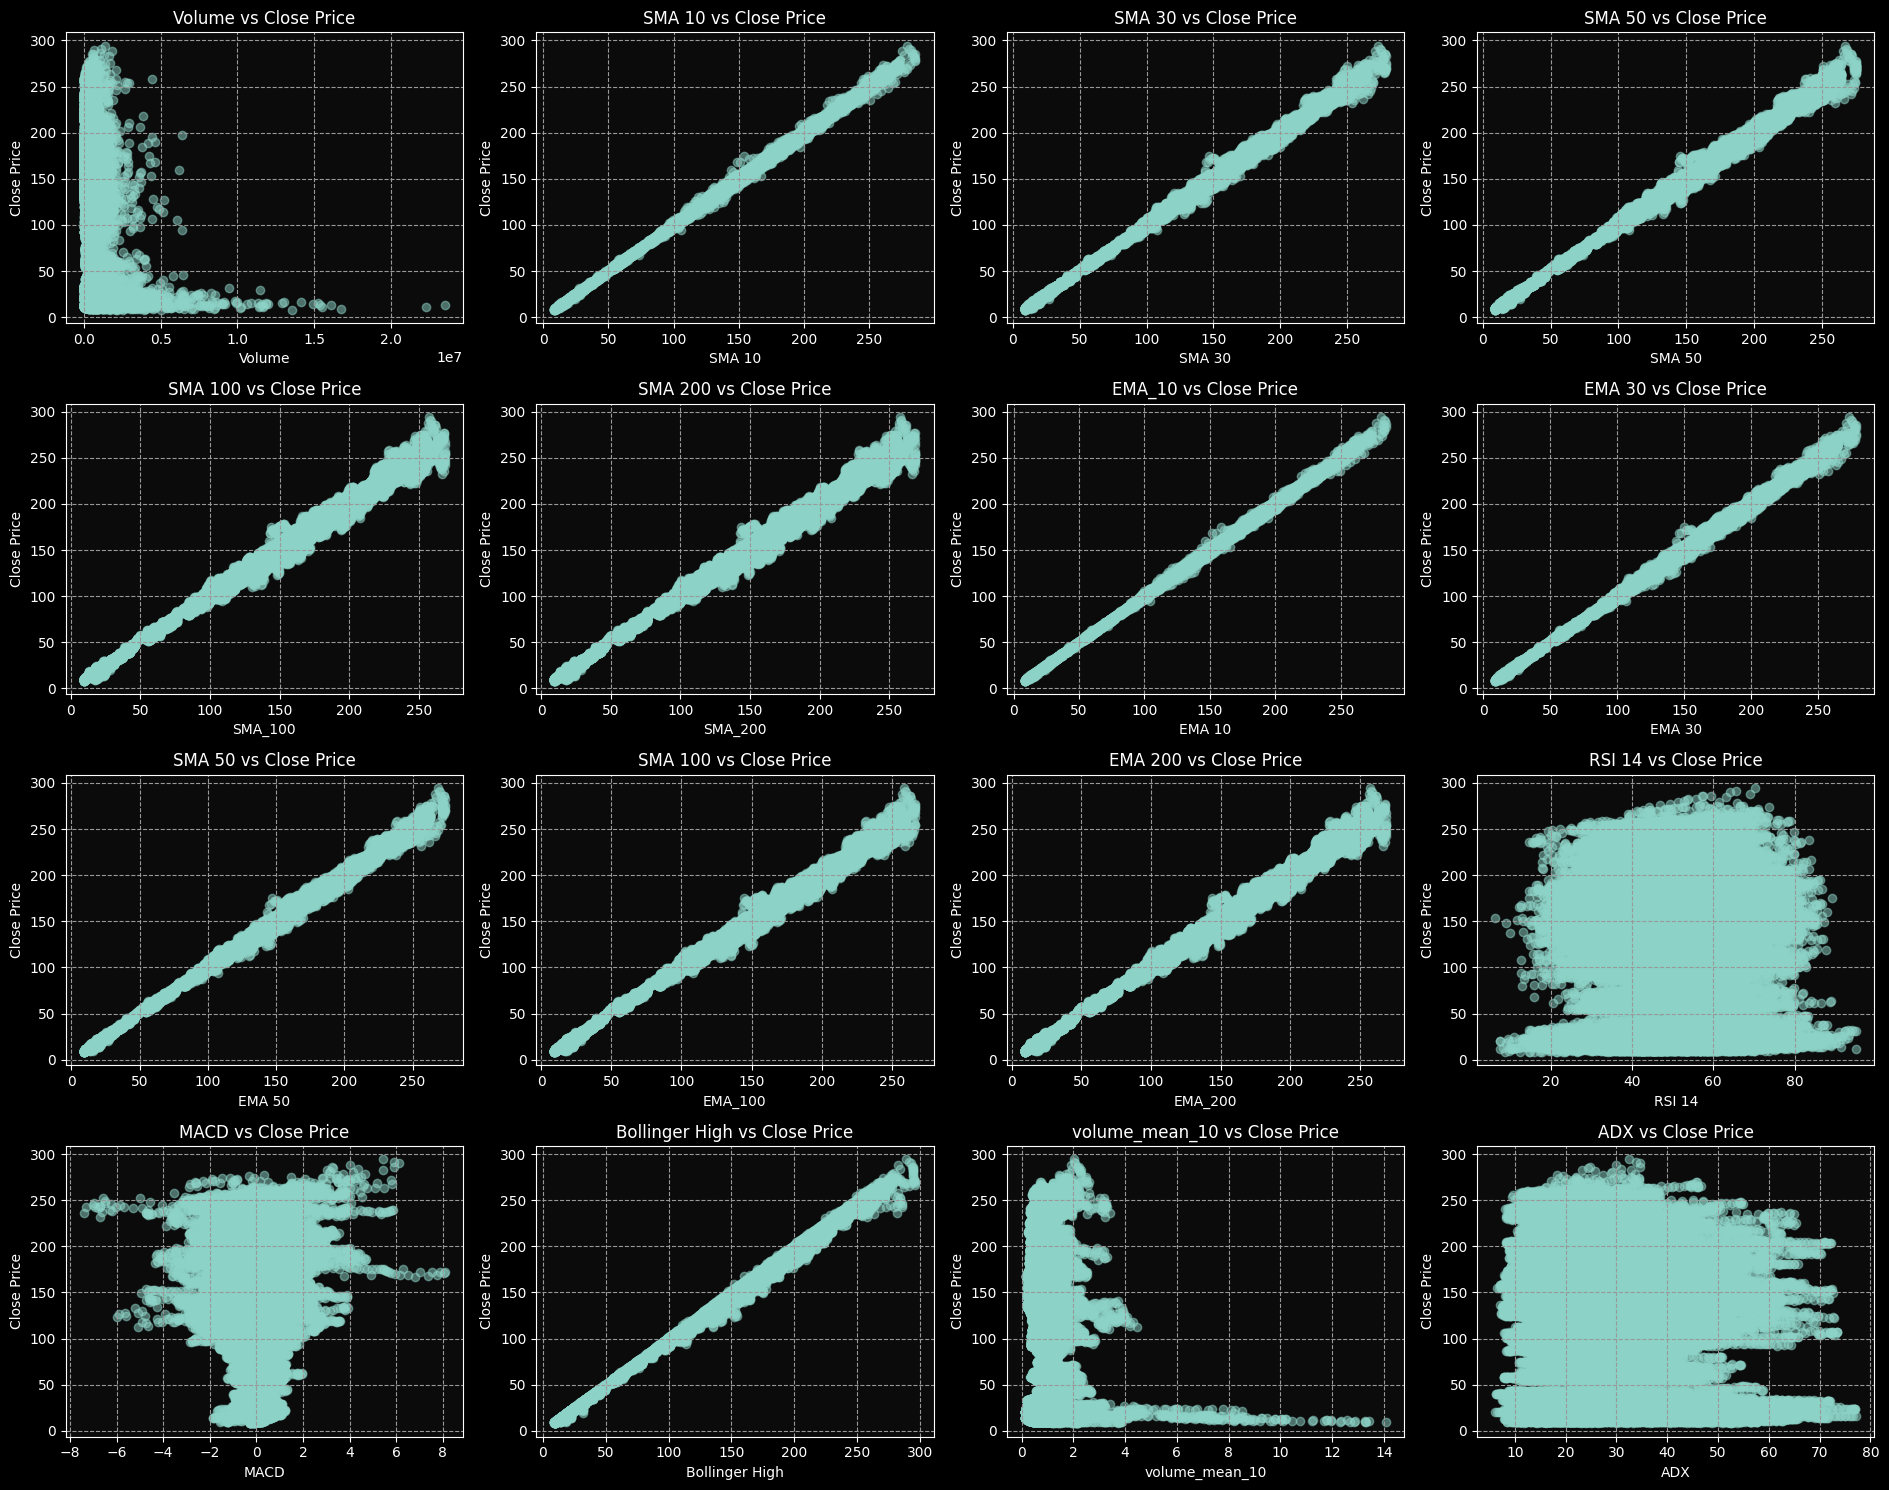

In [ ]:
# Visualizing indicators
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(19, 15))


# Scatter plot: Close price vs volume
axes[0, 0].scatter(data['volume'], data['close'], alpha=0.5)
axes[0, 0].set_xlabel('Volume')
axes[0, 0].set_ylabel('Close Price')
axes[0, 0].set_title('Volume vs Close Price')
axes[0, 0].grid(True)

axes[0, 1].scatter(data['SMA_10'], data['close'], alpha=0.5)
axes[0, 1].set_xlabel('SMA 10')
axes[0, 1].set_ylabel('Close Price')
axes[0, 1].set_title('SMA 10 vs Close Price')
axes[0, 1].grid(True)

axes[0, 2].scatter(data['SMA_30'], data['close'], alpha=0.5)
axes[0, 2].set_xlabel('SMA 30')
axes[0, 2].set_ylabel('Close Price')
axes[0, 2].set_title('SMA 30 vs Close Price')
axes[0, 2].grid(True)

axes[0, 3].scatter(data['SMA_50'], data['close'], alpha=0.5)
axes[0, 3].set_xlabel('SMA 50')
axes[0, 3].set_ylabel('Close Price')
axes[0, 3].set_title('SMA 50 vs Close Price')
axes[0, 3].grid(True)

axes[1, 0].scatter(data['SMA_100'], data['close'], alpha=0.5)
axes[1, 0].set_xlabel('SMA_100')
axes[1, 0].set_ylabel('Close Price')
axes[1, 0].set_title('SMA 100 vs Close Price')
axes[1, 0].grid(True)

axes[1, 1].scatter(data['SMA_200'], data['close'], alpha=0.5)
axes[1, 1].set_xlabel('SMA_200')
axes[1, 1].set_ylabel('Close Price')
axes[1, 1].set_title('SMA 200 vs Close Price')
axes[1, 1].grid(True)


axes[1, 2].scatter(data['EMA_10'], data['close'], alpha=0.5)
axes[1, 2].set_xlabel('EMA 10')
axes[1, 2].set_ylabel('Close Price')
axes[1, 2].set_title('EMA_10 vs Close Price')
axes[1, 2].grid(True)

axes[1, 3].scatter(data['EMA_30'], data['close'], alpha=0.5)
axes[1, 3].set_xlabel('EMA 30')
axes[1, 3].set_ylabel('Close Price')
axes[1, 3].set_title('EMA 30 vs Close Price')
axes[1, 3].grid(True)

axes[2, 0].scatter(data['EMA_50'], data['close'], alpha=0.5)
axes[2, 0].set_xlabel('EMA 50')
axes[2, 0].set_ylabel('Close Price')
axes[2, 0].set_title('SMA 50 vs Close Price')
axes[2, 0].grid(True)

axes[2, 1].scatter(data['EMA_100'], data['close'], alpha=0.5)
axes[2, 1].set_xlabel('EMA_100')
axes[2, 1].set_ylabel('Close Price')
axes[2, 1].set_title('SMA 100 vs Close Price')
axes[2, 1].grid(True)

axes[2, 2].scatter(data['EMA_200'], data['close'], alpha=0.5)
axes[2, 2].set_xlabel('EMA_200')
axes[2, 2].set_ylabel('Close Price')
axes[2, 2].set_title('EMA 200 vs Close Price')
axes[2, 2].grid(True)


axes[2,  3].scatter(data['RSI_14'], data['close'], alpha=0.5)
axes[2,  3].set_xlabel('RSI 14')
axes[2,  3].set_ylabel('Close Price')
axes[2,  3].set_title('RSI 14 vs Close Price')
axes[2,  3].grid(True)


axes[3, 0].scatter(data['MACD'], data['close'], alpha=0.5)
axes[3, 0].set_xlabel('MACD')
axes[3, 0].set_ylabel('Close Price')
axes[3, 0].set_title('MACD vs Close Price')
axes[3, 0].grid(True)


axes[3, 1].scatter(data['bollinger_high'], data['close'], alpha=0.5)
axes[3, 1].set_xlabel('Bollinger High')
axes[3, 1].set_ylabel('Close Price')
axes[3, 1].set_title('Bollinger High vs Close Price')
axes[3, 1].grid(True)


axes[3, 2].scatter(data['historical_volatility'], data['close'], alpha=0.5)
axes[3, 2].set_xlabel('volume_mean_10')
axes[3, 2].set_ylabel('Close Price')
axes[3, 2].set_title('volume_mean_10 vs Close Price')
axes[3, 2].grid(True)


axes[3, 3].scatter(data['ADX'], data['close'], alpha=0.5)
axes[3, 3].set_xlabel('ADX')
axes[3, 3].set_ylabel('Close Price')
axes[3, 3].set_title('ADX vs Close Price')
axes[3, 3].grid(True)

plt.tight_layout()
plt.show()

## Percentage price change algorithm. Target

In [ ]:
# data['return'] is the future return of the next candle relative to the current closing price.
data['return'] = data['close'].pct_change().shift(-1)

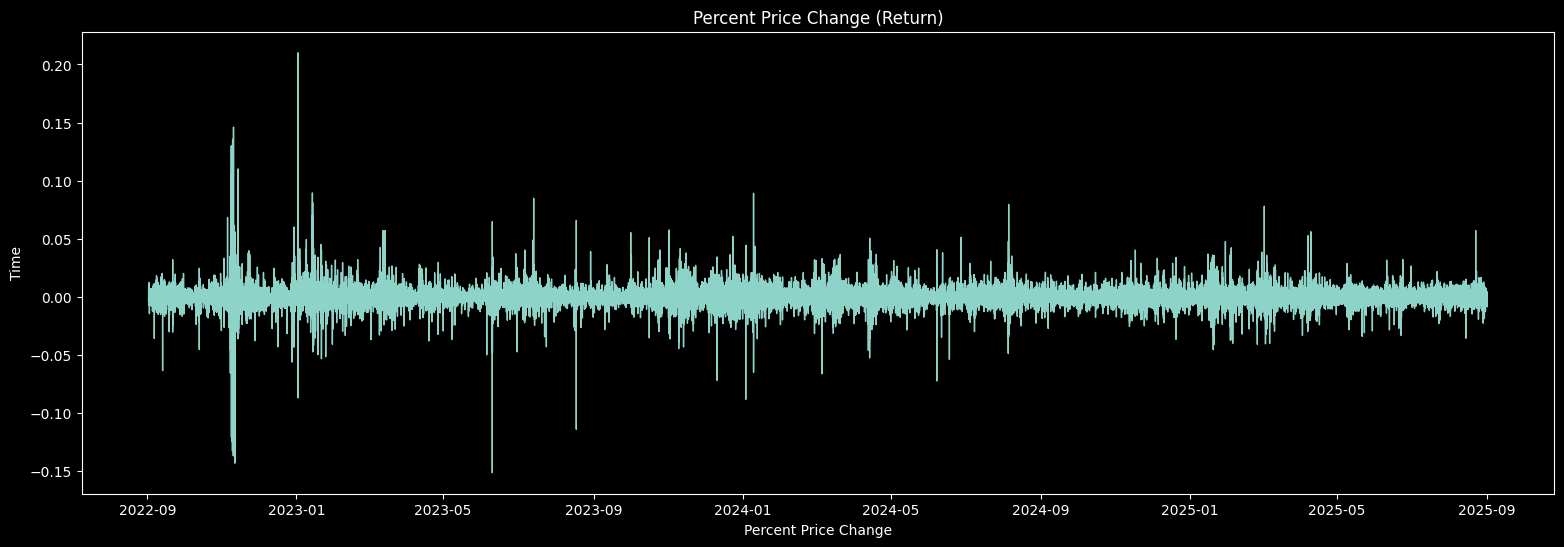

In [ ]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(19,6))
plt.plot(data.index, data['return'])
plt.xlabel('Percent Price Change')
plt.ylabel('Time')
plt.title('Percent Price Change (Return)')
plt.grid()
plt.show()


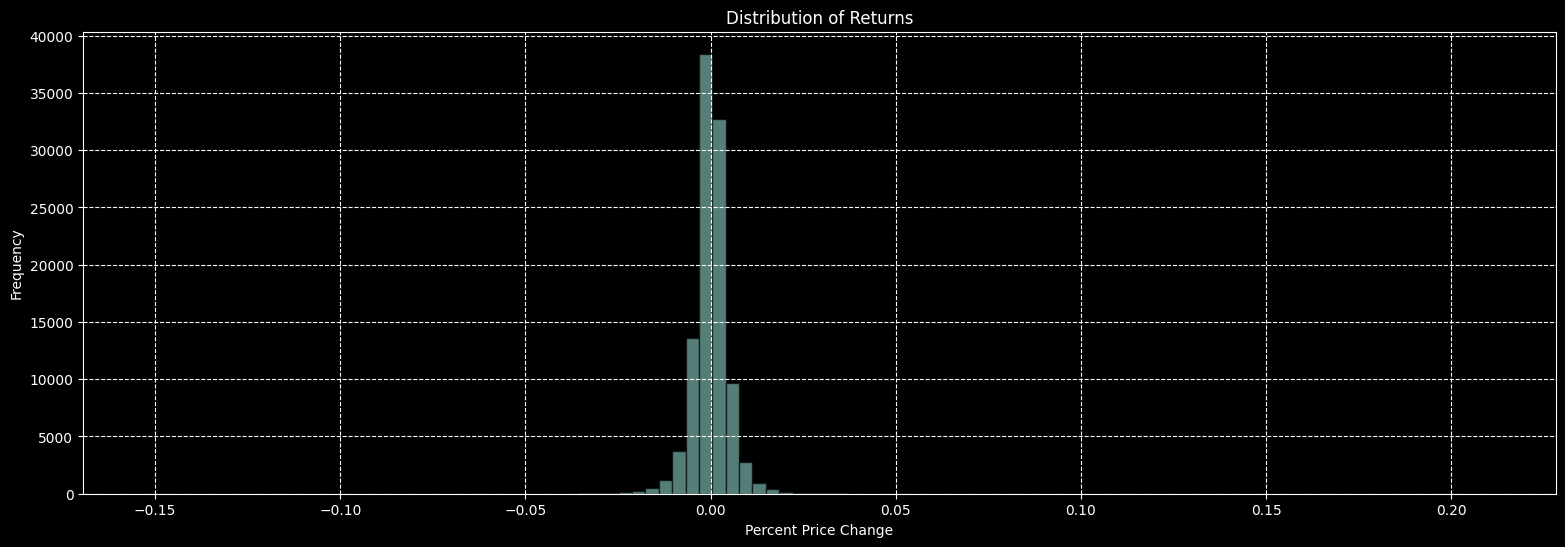

In [ ]:
# simple yield calculation
fig, ax = plt.subplots(figsize=(19, 6))
plt.hist(data['return'], bins=100, edgecolor='black', alpha=0.6)
plt.xlabel('Percent Price Change')
plt.ylabel('Frequency')
plt.title('Distribution of Returns')
plt.show()

Based on the graph, we can judge that the profitability has a normal distribution.

If the price per hour increases by half a percent, then put the mark 1, otherwise mark 0

In [ ]:
import numpy as np


percentage_change = 0.005  # 0.5%

data['price_change'] = data['close'].pct_change() # % price change
future_change = data['price_change'].shift(-1) # % price change of the next candle

conditions = [future_change > percentage_change,
              future_change < -percentage_change
              ]

labels = [1, -1] # 1 - long, -1 - short
data['trade_signal'] = np.select(conditions, labels, default=0)

In [ ]:
data.head()

open   high    low  close    volume   doji  \
Date                                                                     
2022-09-02 00:45:00+00:00  31.31  31.49  31.30  31.44  108079.0  False   
2022-09-02 01:00:00+00:00  31.45  31.53  31.31  31.37  144724.0  False   
2022-09-02 01:15:00+00:00  31.36  31.50  31.35  31.46   78220.0  False   
2022-09-02 01:30:00+00:00  31.46  31.48  31.38  31.38   60667.0  False   
2022-09-02 01:45:00+00:00  31.38  31.40  31.30  31.38   82535.0   True   

                           hammer  inverted_hammer  bullish_engulfing  \
Date                                                                    
2022-09-02 00:45:00+00:00   False            False              False   
2022-09-02 01:00:00+00:00   False            False              False   
2022-09-02 01:15:00+00:00   False            False               True   
2022-09-02 01:30:00+00:00   False            False              False   
2022-09-02 01:45:00+00:00   False            False              False   

                           bearish_engulfing  ...  volume_mean_10  \
Date                                          ...                   
2022-09-02 00:45:00+00:00              False  ...        119402.9   
2022-09-02 01:00:00+00:00              False  ...        119283.6   
2022-09-02 01:15:00+00:00              False  ...        118158.4   
2022-09-02 01:30:00+00:00              False  ...        112752.1   
2022-09-02 01:45:00+00:00              False  ...        111002.7   

                           volume_mean_30  parabolic_SAR        ADX  \
Date                                                                  
2022-09-02 00:45:00+00:00   156379.966667      31.702060  29.368711   
2022-09-02 01:00:00+00:00   151410.433333      31.685978  28.620355   
2022-09-02 01:15:00+00:00   148313.633333      31.670539  27.925454   
2022-09-02 01:30:00+00:00   144704.466667      31.655717  27.280189   
2022-09-02 01:45:00+00:00   141866.366667      31.641489  25.875590   

                                  CCI  stochastic_oscillator_k  \
Date                                                             
2022-09-02 00:45:00+00:00  -55.192308                26.143791   
2022-09-02 01:00:00+00:00  -69.549000                20.379085   
2022-09-02 01:15:00+00:00  -45.334797                28.222222   
2022-09-02 01:30:00+00:00  -64.587394                23.615176   
2022-09-02 01:45:00+00:00 -122.330097                25.695984   

                           stochastic_oscillator_d    return  price_change  \
Date                                                                         
2022-09-02 00:45:00+00:00                39.741776 -0.002226           NaN   
2022-09-02 01:00:00+00:00                27.740741  0.002869     -0.002226   
2022-09-02 01:15:00+00:00                24.915033 -0.002543      0.002869   
2022-09-02 01:30:00+00:00                24.072161  0.000000     -0.002543   
2022-09-02 01:45:00+00:00                25.844461 -0.004780      0.000000   

                           trade_signal  
Date                                     
2022-09-02 00:45:00+00:00             0  
2022-09-02 01:00:00+00:00             0  
2022-09-02 01:15:00+00:00             0  
2022-09-02 01:30:00+00:00             0  
2022-09-02 01:45:00+00:00             0  

[5 rows x 46 columns]

## Data Preprocessing - Stationarity

In [ ]:
df_stationary = make_stationary(data)
df_stationary.head()

In [ ]:
df_stationary.isna().sum()

## Data Preprocessing - Colleration

Outliers in column 'open':
Outlier Count: 1665
Outlier Percentage of total observations: 6.35%
Outlier Values: 0.030931879583465882, -0.019181589781834152, 0.02458894497826236, -0.06129709167403252, -0.020215673197805817, 0.021679387309039733, 0.020757766075487183, 0.019779586086976053, -0.02075002402375903, 0.04101970687268741, -0.022866204459156325, 0.018793263814286032, 0.036743825930495966, 0.019454311084871723, 0.022443530768846642, -0.06921593639976598, -0.020828059829227197, 0.018697680785414672, 0.02510347818904135, -0.02038509727363369, -0.022466123862654896, -0.020341712463955552, -0.02957120157446047, -0.023129845778982805, -0.021033580321038414, 0.01877989465159624, 0.02359539525020038, -0.046491173502303695, -0.027989602607457975, -0.01828091188233394, 0.019550661500739697, 0.028776785015221407, 0.023752639216403804, -0.04281272130718561, 0.019470436853091577, 0.02357262662048809, 0.02573511984310084, -0.018317127912580222, -0.02363231963650758, -0.018185438541278298, 0.02

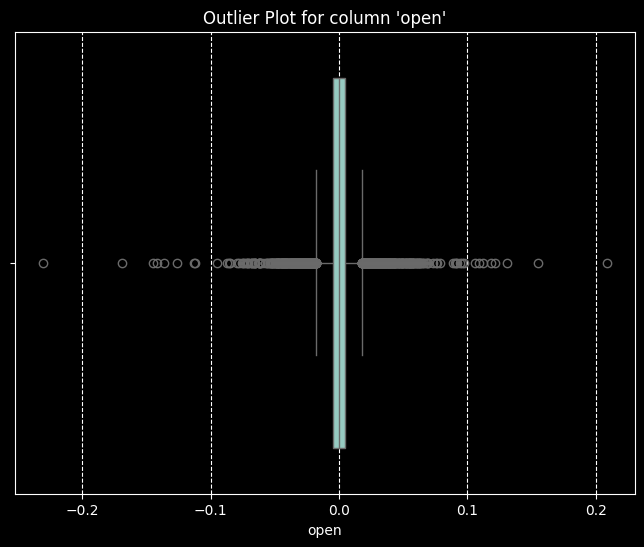

***************************************************************************

Outliers in column 'high':
Outlier Count: 2077
Outlier Percentage of total observations: 7.93%
Outlier Values: 0.03453842240218252, -0.019605514107773114, 0.026620384543363684, -0.0621930152818182, 0.019036305848646684, 0.017835651145663878, -0.01631841581177884, 0.02614335997959083, 0.014750809758148353, 0.015695389463690645, -0.016840139754373595, 0.022460236679750167, 0.037867376642654715, -0.024172059404110158, 0.019059032318362146, 0.019255513308743755, 0.03556775078067176, 0.017451526982645404, 0.025996158878893283, 0.01867758575903755, -0.07369225815895941, -0.01612253845052214, -0.017602532118976555, 0.018907505649063516, 0.031234124160108845, -0.022374898267614185, -0.021723812185244995, 0.02178334331008891, -0.028932835769187815, -0.015662778241951614, 0.014734411346792875, 0.01894760831372544, 0.0159024757940589, -0.016260520871780315, 0.03526201196837997, -0.04447922793015113, -0.027011288490622842

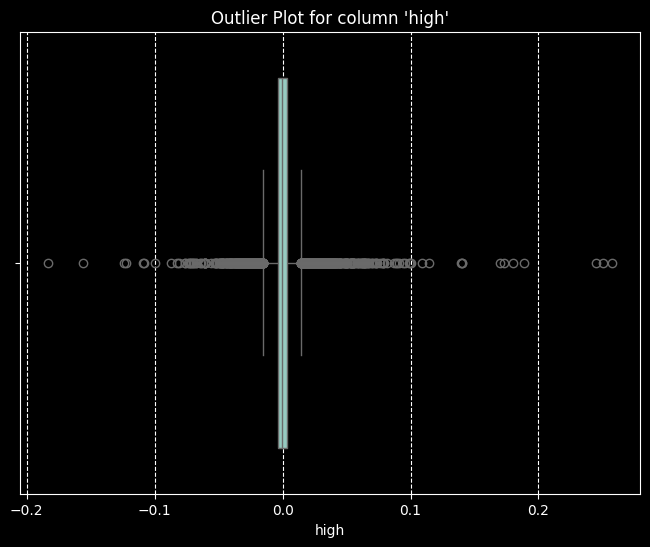

***************************************************************************

Outliers in column 'low':
Outlier Count: 2164
Outlier Percentage of total observations: 8.26%
Outlier Values: -0.0185919960600609, -0.06495789627477233, -0.01871022322806004, 0.02148520145078603, -0.017808269207373773, 0.021850384621253216, 0.0180657593952267, -0.01909227793484014, -0.016905095095963052, 0.02047470206063151, 0.03250320261072126, -0.01749001936071437, 0.02114356832875952, -0.0731835533664027, -0.01945141419118812, -0.021468767694831303, -0.024941910524689526, 0.01817419306489887, 0.016112219661864824, -0.015981042660681233, -0.018493781595131598, 0.01818502937103661, 0.030975262454487673, -0.018674964893349077, -0.02238203472420741, -0.015713711135163067, -0.02006956683595984, -0.015466570631956778, -0.04261376066782807, -0.030094489209101738, 0.017462246024198436, -0.018916074741093247, -0.04796771766117347, 0.04511555283749047, -0.025679941944890317, -0.01988260588656887, 0.01986409200009298,

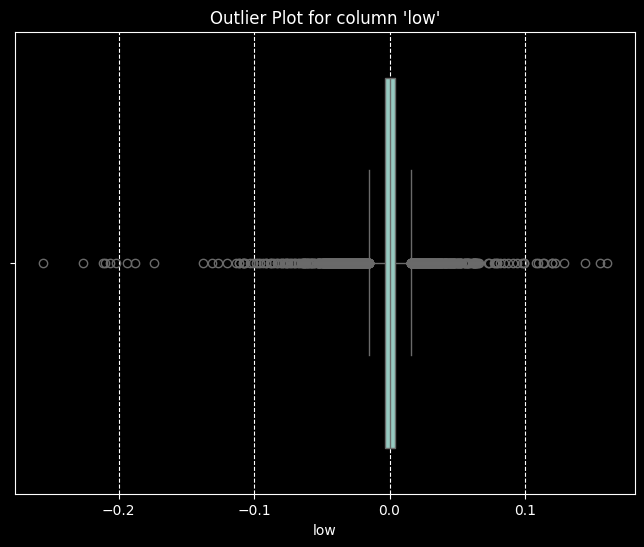

***************************************************************************

Outliers in column 'close':
Outlier Count: 1665
Outlier Percentage of total observations: 6.35%
Outlier Values: 0.030931879583465882, -0.019181589781834152, 0.024885109647982517, -0.06129709167403252, -0.020215673197805817, 0.02137296781836273, 0.020449362063790666, 0.0200734012793351, -0.02075002402375903, 0.041031396677862375, -0.022872661665991778, 0.018505866197708, 0.036476553444606985, 0.019718198142743226, 0.02217964371097514, -0.06947611592510494, -0.020828059829227197, 0.018697680785414672, 0.024807926243635592, -0.02009093636549686, -0.02186697882655686, -0.020045547794235397, -0.02925196773296257, -0.022812234215252136, -0.02102697899339301, 0.019709694811562706, 0.022968396000950353, -0.046793974413020134, -0.027989602607457975, 0.019857928364425792, 0.0281708769666964, 0.024361740740035387, -0.04310371505287325, 0.019470436853091577, 0.02386748140664352, 0.026028074290779468, -0.02363231963650758,

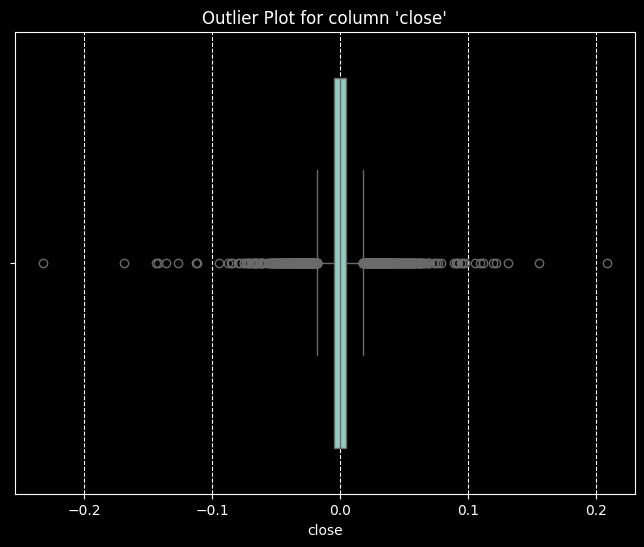

***************************************************************************

Outliers in column 'volume':
Outlier Count: 2041
Outlier Percentage of total observations: 7.79%
Outlier Values: 5115045.0, 4156510.0, 6017332.0, 6074167.0, 3701304.0, 2949030.0, 3186380.0, 7068820.0, 3254206.0, 4549233.0, 2780531.0, 2801142.0, 2861736.0, 2804133.0, 2849251.0, 3765259.0, 3353460.0, 4125844.0, 3481884.0, 2760836.0, 2920692.0, 2748480.0, 3078707.0, 7008183.0, 7078796.0, 4434079.0, 3029662.0, 4282227.0, 3944360.0, 2625787.0, 6842812.0, 3735327.0, 2690443.0, 2834514.0, 10879486.0, 8517531.0, 4055031.0, 3846782.0, 2945255.0, 3795652.0, 3965918.0, 5830306.0, 3919564.0, 2846895.0, 2770558.0, 3637861.0, 5886690.0, 4512499.0, 3460345.0, 9755696.0, 2962827.0, 5010943.0, 16894746.0, 12063590.0, 15416791.0, 13034895.0, 6298102.0, 5202526.0, 5505857.0, 3426388.0, 3861045.0, 2917021.0, 3620743.0, 10920173.0, 7266400.0, 21022116.0, 25296436.0, 26819143.0, 24160718.0, 13616832.0, 6895132.0, 3323034.0, 5769094

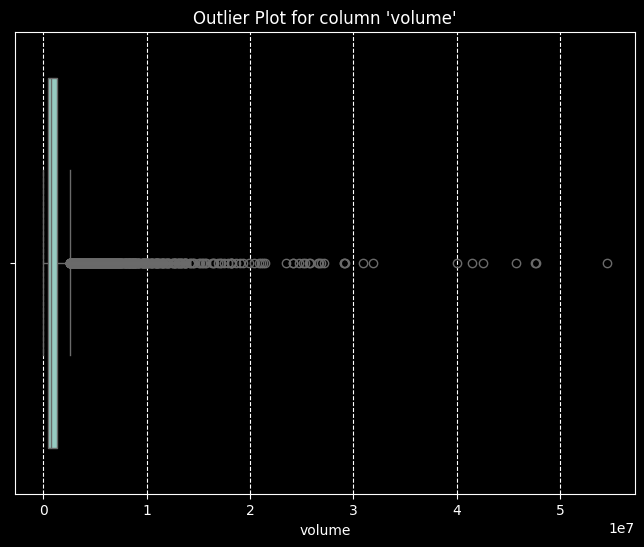

***************************************************************************

No outliers in column 'doji' as it has binary values.
***************************************************************************

No outliers in column 'hammer' as it has binary values.
***************************************************************************

No outliers in column 'inverted_hammer' as it has binary values.
***************************************************************************

No outliers in column 'bullish_engulfing' as it has binary values.
***************************************************************************

No outliers in column 'bearish_engulfing' as it has binary values.
***************************************************************************

No outliers in column 'piercing_line' as it has binary values.
***************************************************************************

No outliers in column 'dark_cloud' as it has binary values.
*****************************

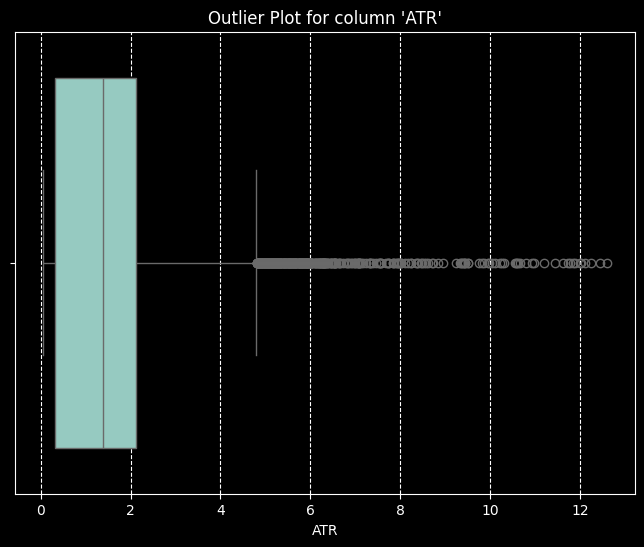

***************************************************************************

Outliers in column 'historical_volatility':
Outlier Count: 1341
Outlier Percentage of total observations: 5.12%
Outlier Values: 3.0098359573987485, 2.8947652848317875, 2.90124301976644, 2.843596116616529, 3.2519492707906674, 3.9113972018467327, 3.997011295993503, 4.49544931964437, 4.660845111829452, 4.547792783320301, 4.388903498183042, 4.2566735496993795, 4.1940856232959, 4.11953757791814, 3.9041156097860803, 4.079356654800829, 4.19829154573662, 4.122247154137081, 4.736764980627087, 6.42612253030966, 7.664048901937677, 9.042426065197509, 9.033173396676016, 8.548543253910424, 8.308420041277142, 8.04383434136369, 8.27753665385025, 8.297638103274334, 8.441877257255106, 8.276150586182007, 8.050904079150968, 8.95894172589608, 8.991458490102286, 9.294030725464761, 11.892620985953693, 12.344092713336599, 12.584584733618371, 11.457740136768352, 11.654285393906775, 11.981771506429997, 12.26652470095409, 17.06186993276

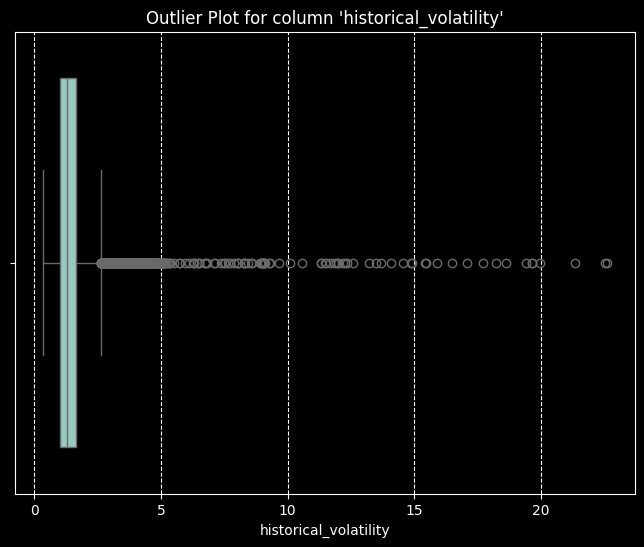

***************************************************************************

Outliers in column 'SMA_10':
Outlier Count: 1384
Outlier Percentage of total observations: 5.28%
Outlier Values: -0.006849446099754797, -0.006097299625254848, -0.0065431662235875265, -0.009157747869296351, -0.00943584894281635, 0.0069277128946101385, 0.010078346665677085, 0.008075862227438169, 0.008669023509053186, 0.007561627512794544, 0.0064246144619453105, 0.006571529170328105, -0.008874901888195286, -0.00863414101500748, -0.009678748961688743, -0.008848777109568662, -0.009778292704847313, -0.011095278317944768, -0.011977862968511221, -0.013061733296290345, -0.013061597244036882, -0.007204996518252571, -0.007052544240150116, -0.006059511746890234, -0.006714328538647951, -0.007039771052659294, 0.006520344770085895, 0.006847018083149692, 0.007624392002830049, 0.007687787601379004, 0.006847792185237456, 0.007099770697312824, -0.006089288694352657, -0.00622253481153523, -0.006895852190396123, -0.006426601480967

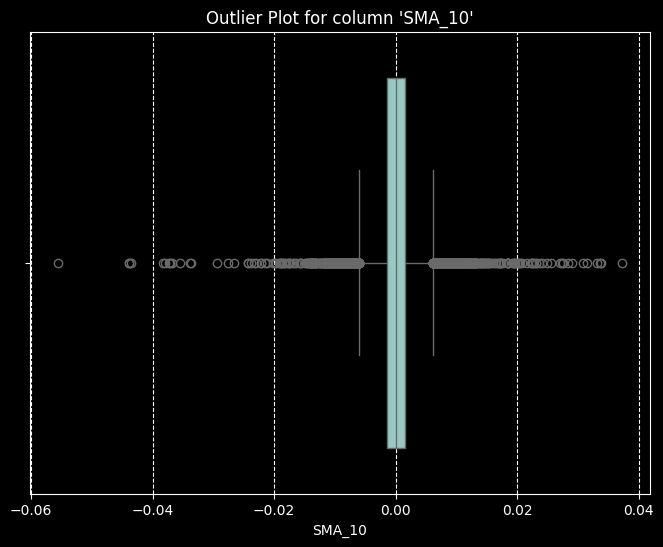

***************************************************************************

Outliers in column 'SMA_30':
Outlier Count: 1190
Outlier Percentage of total observations: 4.54%
Outlier Values: 0.003860868026672737, -0.004197688788036835, -0.0040596197291651315, -0.0038462115462767343, -0.0037600550640677355, -0.004094913445430226, -0.004983532538959334, -0.004436998676033088, -0.0048777092293934565, -0.004642026270740729, -0.004798899104988763, -0.004608526169418425, -0.0047078593281124625, -0.005024055608177758, -0.005039575671918595, 0.004025527244350791, 0.00413942308475157, 0.0049175699007117935, 0.004903210523800716, 0.004425278717437919, 0.0038940671968688, 0.0038674866918175788, -0.004184281987567484, -0.003986193976603936, -0.004100703807724759, -0.004351757544702295, -0.004265578908506207, -0.004456741118144425, -0.004274086712895642, -0.004776971361439397, -0.004215685851772122, -0.004614844939029972, -0.004321904834429624, -0.003916595408016477, -0.0042884169947887685, -0.00486

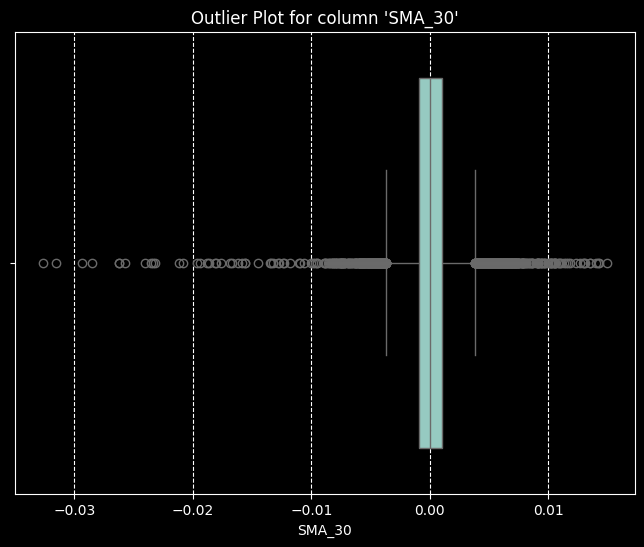

***************************************************************************

Outliers in column 'SMA_50':
Outlier Count: 1106
Outlier Percentage of total observations: 4.22%
Outlier Values: -0.0031256175383278517, 0.003781935349856269, 0.003737600955894038, 0.00341190652714074, 0.003492280245091184, 0.0032128541693254853, 0.0033979449350973745, 0.0033746378880312733, 0.003369168258449573, 0.0032582210773850484, -0.0031697227786895432, -0.003567038728522931, -0.004331658858007348, -0.004404038409393518, -0.004704375867149224, -0.0046545564718978305, -0.0052314693045776295, -0.005604900487144349, -0.005453385963300139, -0.006060290709332339, -0.005090792494053087, -0.004744725223506663, -0.004792266971358483, -0.004627541770033883, -0.005032735887238626, -0.005140394230192413, -0.004906383056415109, -0.00535852671042969, -0.00542593538237357, -0.005100376196444767, -0.0042702757101826805, -0.006354968261434113, -0.007742785588408463, -0.007949020504590898, -0.007645281916662139, -0.00719

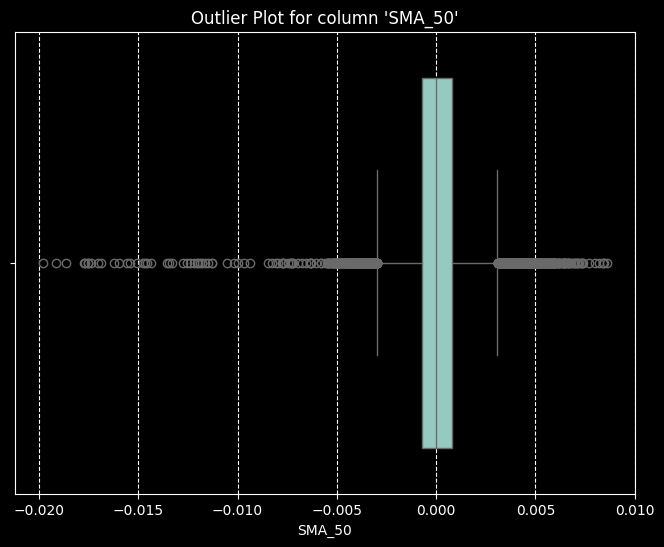

***************************************************************************

Outliers in column 'SMA_100':
Outlier Count: 900
Outlier Percentage of total observations: 3.43%
Outlier Values: -0.0023455622372443585, -0.0031938277838374773, -0.00315215332792107, -0.003064110136515641, -0.002876931950376971, -0.0030854774894986114, -0.0029837735216542427, -0.0033926144193130447, -0.0036748815491751685, -0.003947730507473768, -0.0039131886658814174, -0.004423082018135016, -0.004879545162646881, -0.005008468988008552, -0.005254363198620382, -0.006153924808808053, -0.006302141689969343, -0.006397521304075671, -0.0058090378078627936, -0.005903330453669309, -0.006176285701949613, -0.006282120636595501, -0.0075417540180597875, -0.007290601490796966, -0.007878604374383702, -0.008052736712731434, -0.008805391145310981, -0.00958241871294696, -0.009468675769379598, -0.008738373203283523, -0.009096164921291283, -0.008843221538218593, -0.009515609545574844, -0.009403172175980412, -0.008486869722720947

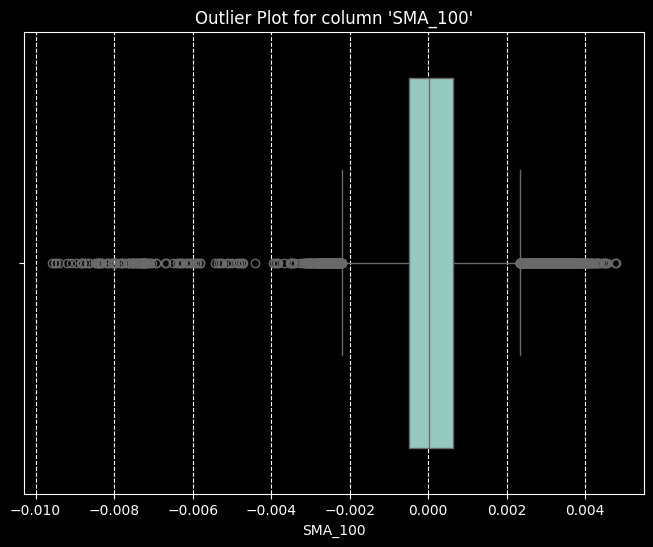

***************************************************************************

Outliers in column 'SMA_200':
Outlier Count: 900
Outlier Percentage of total observations: 3.43%
Outlier Values: -0.0023455622372443585, -0.0031938277838374773, -0.00315215332792107, -0.003064110136515641, -0.002876931950376971, -0.0030854774894986114, -0.0029837735216542427, -0.0033926144193130447, -0.0036748815491751685, -0.003947730507473768, -0.0039131886658814174, -0.004423082018135016, -0.004879545162646881, -0.005008468988008552, -0.005254363198620382, -0.006153924808808053, -0.006302141689969343, -0.006397521304075671, -0.0058090378078627936, -0.005903330453669309, -0.006176285701949613, -0.006282120636595501, -0.0075417540180597875, -0.007290601490796966, -0.007878604374383702, -0.008052736712731434, -0.008805391145310981, -0.00958241871294696, -0.009468675769379598, -0.008738373203283523, -0.009096164921291283, -0.008843221538218593, -0.009515609545574844, -0.009403172175980412, -0.008486869722720947

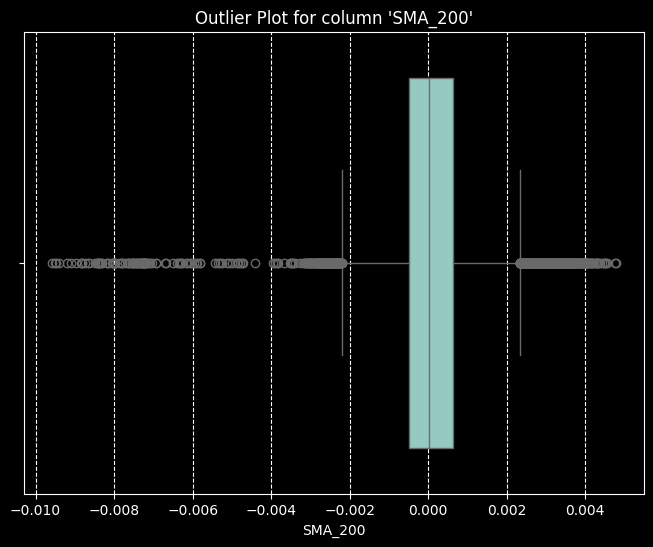

***************************************************************************

Outliers in column 'EMA_10':
Outlier Count: 1750
Outlier Percentage of total observations: 6.68%
Outlier Values: 0.006990626861383298, -0.009053048106809403, -0.010990610997158257, -0.008235656174460093, -0.005823045456047282, 0.005732679812127994, 0.006424337688859527, 0.006180108768717663, 0.011342780752936932, 0.01196490846889775, 0.00833387252002371, 0.007909890196332814, 0.007017294819776421, 0.006538161654353392, -0.01134506576090244, -0.011712253804001094, -0.011850318010674599, -0.010895944161492643, -0.007598414689003796, -0.006613540479186497, -0.009106196036157588, -0.00833454374690934, -0.007802987144531315, -0.006377741019498284, -0.007924273432654338, -0.008700926952542876, -0.005842183640739851, 0.006272472930725748, -0.007536363672191904, -0.0067164333784841546, -0.0064942041813353946, -0.006168522502904228, 0.006677498440851082, -0.007083206648947016, -0.0061217401928779225, 0.0088703360998221

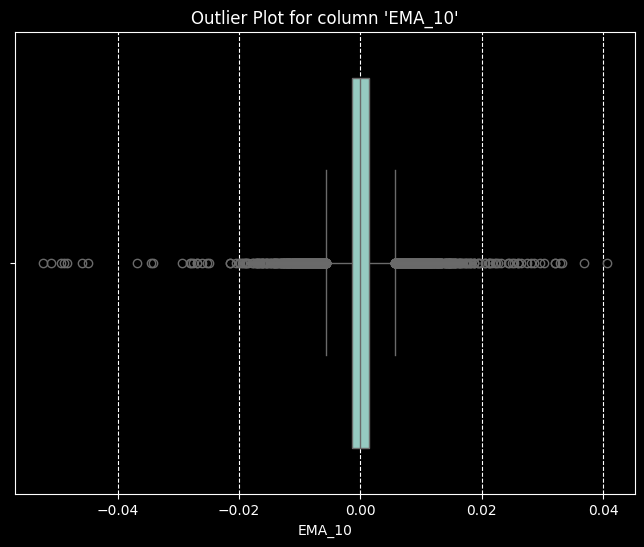

***************************************************************************

Outliers in column 'EMA_30':
Outlier Count: 1381
Outlier Percentage of total observations: 5.27%
Outlier Values: 0.003643331695581953, 0.0037435580274367553, 0.0037045658524528235, 0.004426458255887056, 0.005127816811209218, 0.004282608824238476, 0.004406123799439943, 0.004320623137574309, -0.00402144296436413, -0.004160704460326681, -0.004396025495115641, -0.004413654750047069, -0.004467170379935936, -0.00417922305156182, -0.004841673490878939, -0.005291155638209588, -0.004521406830069186, -0.003847366695696408, -0.0034985589475815537, -0.003987985053576004, -0.0039564109402463465, -0.004203265325279926, 0.006338142409259451, 0.007588382040199182, 0.005895569627708763, 0.005263540962920477, 0.003691977818314651, 0.00392281472263889, 0.003673359844243329, 0.0044853497797818775, 0.0038055140934392107, 0.003625051725919537, 0.005923420471295682, 0.0064454797234261285, 0.004429019351020802, 0.004309492955998806, 

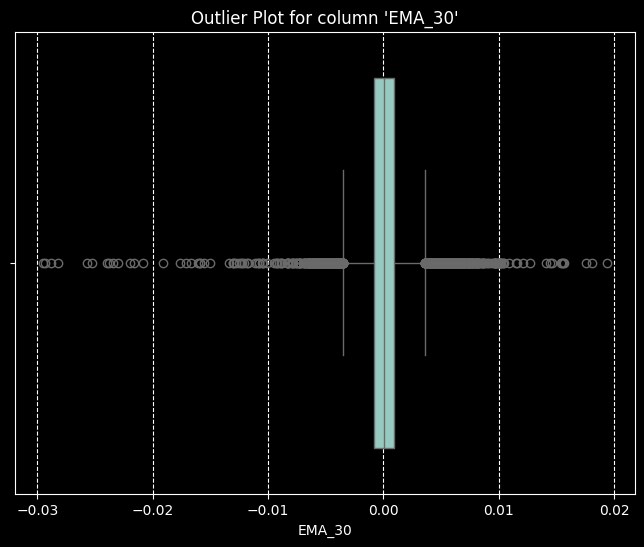

***************************************************************************

Outliers in column 'EMA_50':
Outlier Count: 1209
Outlier Percentage of total observations: 4.61%
Outlier Values: 0.0033593324935772273, 0.002916072937184655, 0.0030493647605025487, 0.0030540087560360085, -0.0030040554846748613, -0.0033424765729352934, -0.002948063312713245, -0.0029776187910766083, 0.003928747181101588, 0.004797426283793982, 0.0038813942648272537, 0.0035796616135921333, 0.00312209554401921, 0.004335232727271432, 0.004727969113946351, 0.0035507795652072183, 0.0035179135989835686, 0.002967279351508534, 0.003196869742461139, 0.002970784326685738, -0.003995081158391756, -0.003034023034716782, -0.003143612269865592, -0.004430466155247448, -0.004012410762929797, -0.004530168193837003, -0.00427550060042492, -0.005808868295193559, -0.007199213862928655, -0.006462030177405875, -0.00716379616556484, -0.004789912141136998, -0.004498836224464231, -0.0040529866623884026, -0.0031793958628560937, -0.003733529

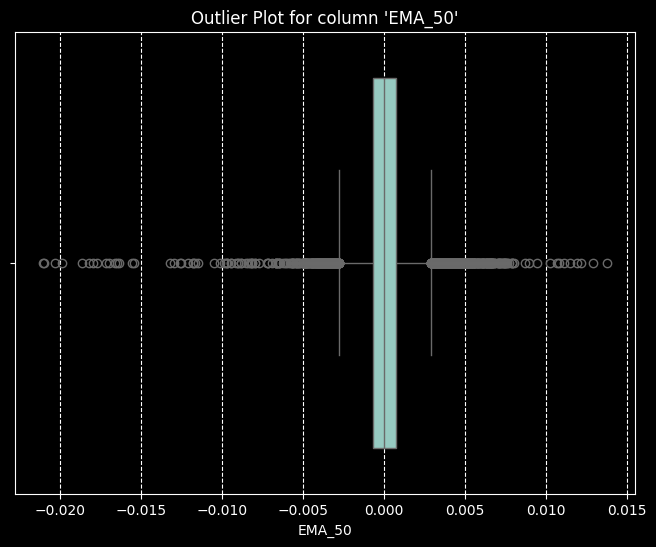

***************************************************************************

Outliers in column 'EMA_100':
Outlier Count: 1044
Outlier Percentage of total observations: 3.98%
Outlier Values: 0.00244551840769347, 0.002611882886345729, 0.0028532690074905, 0.002286728217056666, 0.002312208531483506, -0.0023619012080500212, -0.0021892947145163433, -0.0024794999780044513, -0.002388419271052822, -0.0031823145712239764, -0.003913777630152548, -0.0036027219149943335, -0.003994133444565673, -0.002880576192307416, -0.0027704247709734453, -0.002581936478220026, -0.00218066872092626, -0.0024686888940292917, -0.002574011196337711, -0.0022445869045273348, -0.0028755419122350467, -0.002901387026744917, -0.002552351029187605, -0.004011004503712723, -0.005253144235215057, -0.005467979373566578, -0.005210205574940119, -0.004864189054432533, -0.005048672353724193, -0.004462068000855801, -0.00519311281261059, -0.005535234050033644, -0.0059424533532053125, -0.0058526336497823905, -0.006016577186689354, -0.

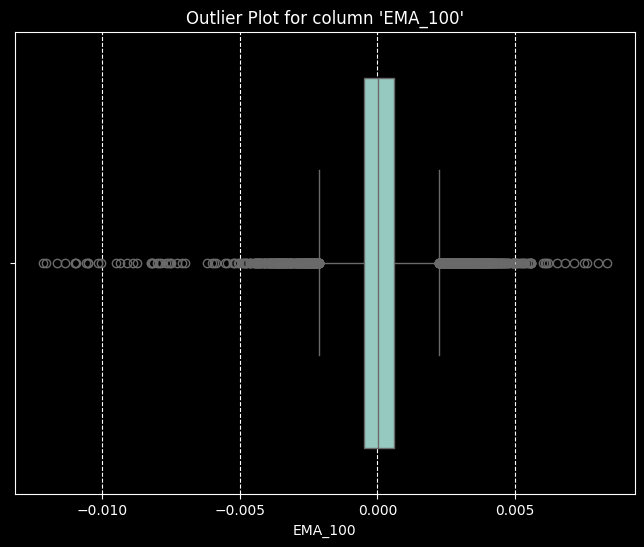

***************************************************************************

Outliers in column 'EMA_200':
Outlier Count: 900
Outlier Percentage of total observations: 3.43%
Outlier Values: -0.0023455622372443585, -0.0031938277838374773, -0.00315215332792107, -0.003064110136515641, -0.002876931950376971, -0.0030854774894986114, -0.0029837735216542427, -0.0033926144193130447, -0.0036748815491751685, -0.003947730507473768, -0.0039131886658814174, -0.004423082018135016, -0.004879545162646881, -0.005008468988008552, -0.005254363198620382, -0.006153924808808053, -0.006302141689969343, -0.006397521304075671, -0.0058090378078627936, -0.005903330453669309, -0.006176285701949613, -0.006282120636595501, -0.0075417540180597875, -0.007290601490796966, -0.007878604374383702, -0.008052736712731434, -0.008805391145310981, -0.00958241871294696, -0.009468675769379598, -0.008738373203283523, -0.009096164921291283, -0.008843221538218593, -0.009515609545574844, -0.009403172175980412, -0.008486869722720947

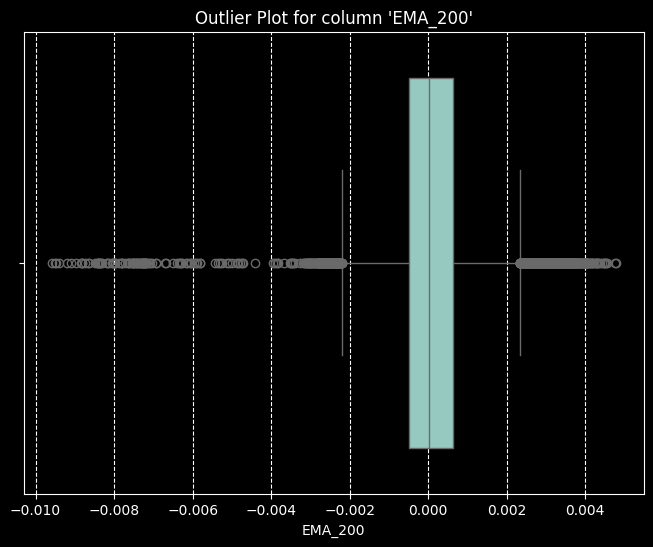

***************************************************************************

Outliers in column 'RSI_14':
Outlier Count: 163
Outlier Percentage of total observations: 0.62%
Outlier Values: 16.874878052163744, 16.784288842839953, 14.51810920762909, 11.294426093006543, 10.806841599783297, 9.762898102969855, 87.22149626606854, 89.50280176682445, 17.799431895299662, 16.146548810144264, 15.71551682603933, 14.888877269960933, 16.341192021798932, 17.784237242316276, 16.87637942696278, 16.800339523526148, 16.667848928726347, 16.434808541495133, 85.88476284055818, 86.71953972891842, 84.39964752743025, 82.38515365670041, 86.35382610364303, 87.46913556573782, 83.53466271992687, 85.06991939738184, 86.04646638803027, 86.15669667145613, 87.2497655248089, 87.92389968606199, 88.65970802907013, 85.33269081793563, 88.01772608620175, 88.30216720738984, 89.09557926050104, 84.36559126668149, 83.59276250745961, 83.99221915497435, 83.70446743079137, 86.60430908194093, 89.6764721745193, 84.48953701306031, 85.

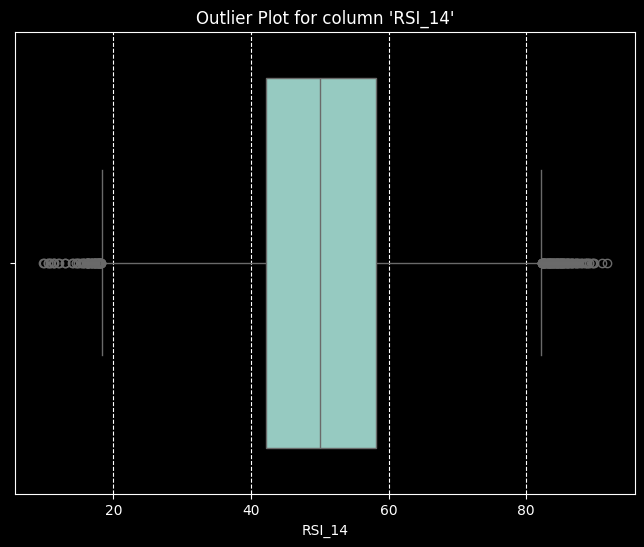

***************************************************************************

Outliers in column 'MACD':
Outlier Count: 4399
Outlier Percentage of total observations: 16.79%
Outlier Values: -1.602630911055904, -1.5537550431984393, -1.549353490513937, -1.7021501802992276, -1.7689606901845778, -1.8330548424858115, -1.7993616017818148, -1.8505778764236176, -1.920669511810516, -2.01272797814714, -2.061118765412047, -2.1050589119539325, -2.2407378425841387, -2.344637428205136, -2.460745224025519, -2.74942517546285, -2.9697935114839744, -3.0758964127941546, -2.967619239600772, -2.8851044259637852, -2.838392199599035, -2.775989262138342, -2.964135231225967, -3.045854890981502, -3.2175628307787854, -3.3540341473632225, -3.3660155589622747, -3.456143268232619, -3.5078713222964772, -3.396981662975609, -3.2465811417074004, -3.0458789539137054, -2.958184887079172, -2.8182743231822673, -2.465224458896291, -2.1491970785138736, -1.8813329248978619, -1.6347916885901839, 1.710835287964489, 1.79393928484

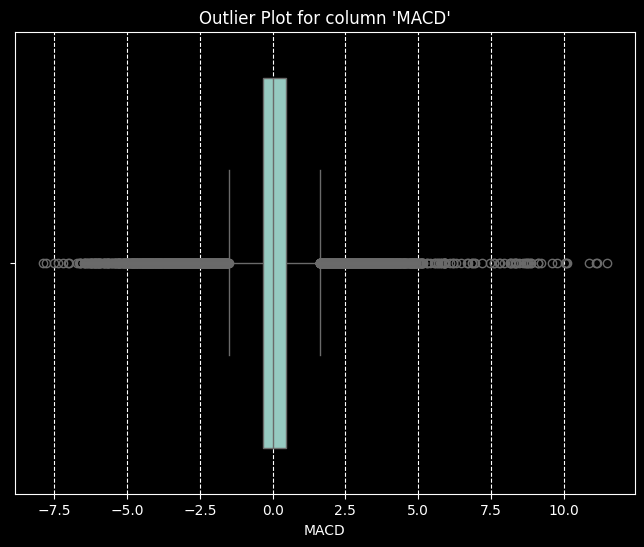

***************************************************************************

Outliers in column 'MACD_signal':
Outlier Count: 4293
Outlier Percentage of total observations: 16.38%
Outlier Values: -1.4813085800846195, -1.5449191844240586, -1.6060509228239703, -1.6689746406212795, -1.7377253081264517, -1.8024039995835708, -1.862934982057643, -1.9384955541629423, -2.019723928971381, -2.1079281879822087, -2.236227585478337, -2.3829407706794643, -2.5215318991024023, -2.610749367202076, -2.6656203789544177, -2.700174743083341, -2.7153376468943415, -2.7650971637606667, -2.8212487092048337, -2.900511533519624, -2.9912160562883434, -3.0661759568231295, -3.1441694191050273, -3.216909799743317, -3.2529241723897755, -3.2516555662533007, -3.210500243785382, -3.16003717244414, -3.0916846025917653, -2.96639257385267, -2.802953474784911, -2.618629364807501, -2.4218618295640377, -2.216489962771562, -2.039423216885017, -1.8772009614546232, -1.7425801779077303, -1.605258773532652, -1.4481663441988117, 1.

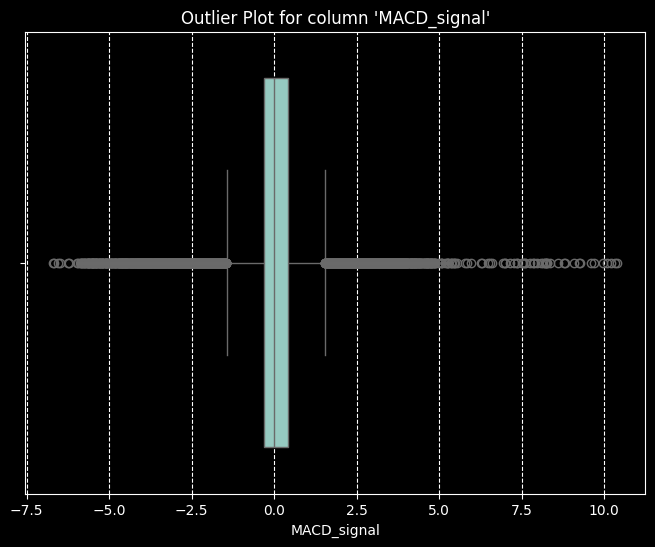

***************************************************************************

Outliers in column 'bollinger_high':
Outlier Count: 3119
Outlier Percentage of total observations: 11.90%
Outlier Values: 0.009827496607836661, 0.007004781899147883, -0.006716066095907358, -0.005480819360308864, -0.005106542536396752, -0.007343772161323869, -0.01860963784806069, -0.027184711961449004, 0.006959195389628192, 0.005153094349225729, 0.00850469418967048, 0.006313422716848649, 0.006530548242040801, 0.005114340952788066, 0.0058231596206548275, 0.008724728369324808, 0.008128201265269919, 0.007093237493836835, 0.0060649969233117496, 0.005047164708669616, 0.005770271380173941, 0.005709211740271947, 0.0050651056183821375, 0.016285319182693492, 0.01637536929777772, 0.010427446121307415, 0.009728699365751048, 0.009570506861472428, 0.0060606773702169825, -0.005107025861933678, -0.006506759792419103, 0.005964880418287688, 0.006608200349885518, 0.0062492308868709046, -0.005133993767262535, -0.00516716115842630

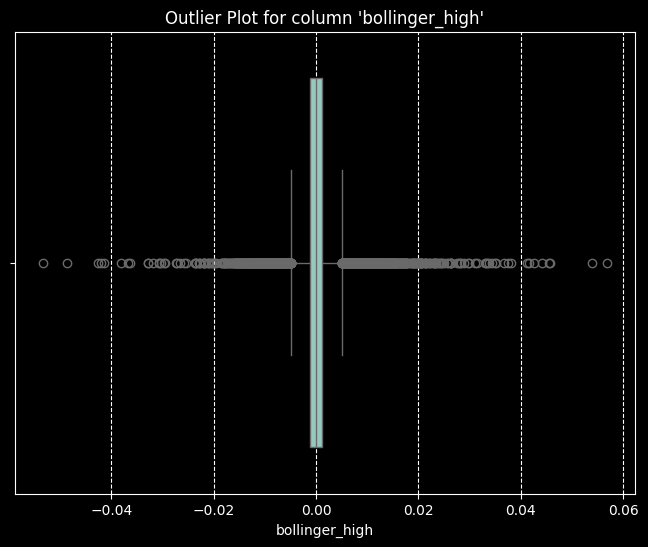

***************************************************************************

Outliers in column 'bollinger_mid':
Outlier Count: 1092
Outlier Percentage of total observations: 4.17%
Outlier Values: 0.004694947950399708, -0.006222333870161023, -0.008009837183923008, -0.006940987893138129, -0.006876834016916522, -0.006456602985374538, -0.007012282398280334, -0.006242771666914226, -0.006845837460144555, -0.007504807358784227, -0.007737746401913714, -0.004580606561196188, 0.005044942120523199, 0.006531019322051801, 0.005505077522814705, 0.005543614093696636, 0.004943753676270202, 0.004691044429494973, 0.004849550441868189, 0.004842466027879855, 0.005078962570276957, 0.0051825335443664855, 0.004745632849775028, 0.005349804031046901, 0.00595056350333234, 0.0047145523208032, -0.004830858629747414, -0.005312400926373417, -0.005372114193244126, -0.005474120851604702, -0.005665737535677451, -0.0061558593875759016, -0.007413591869608993, -0.006315103285003509, -0.006536118290239035, -0.00609366135

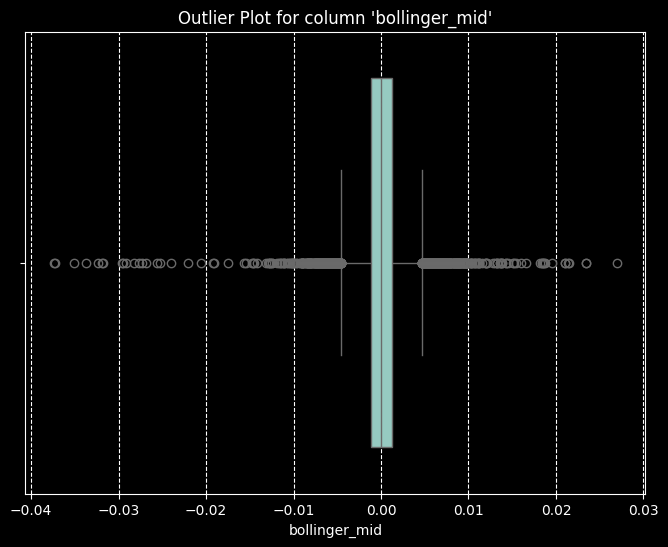

***************************************************************************

Outliers in column 'bollinger_low':
Outlier Count: 3148
Outlier Percentage of total observations: 12.01%
Outlier Values: -0.006912476701082859, -0.005467783573954055, -0.011698919968758048, -0.008035713154177504, -0.007286541694552007, -0.006448447248331934, -0.006018499257698373, -0.006941517186356272, -0.005554126944643301, -0.006847371282016734, 0.0115338380891572, 0.020785769102921847, 0.005781108262226553, 0.006777508257557852, 0.005476100601355949, 0.005987474425274808, 0.006846971569761884, -0.009599578644921447, -0.008324649708754794, 0.008924425265488534, 0.0068595125269412804, 0.008556155178364389, 0.009797201405230105, 0.012411954627629118, 0.015670073064482093, 0.010160644364055393, 0.0086071911500194, -0.01011416687244271, -0.013205901324414349, -0.014494943641953917, -0.013760229958940773, -0.010035125331476102, -0.009110247948816763, -0.012588283336120831, -0.01235567570079077, -0.01189876790704

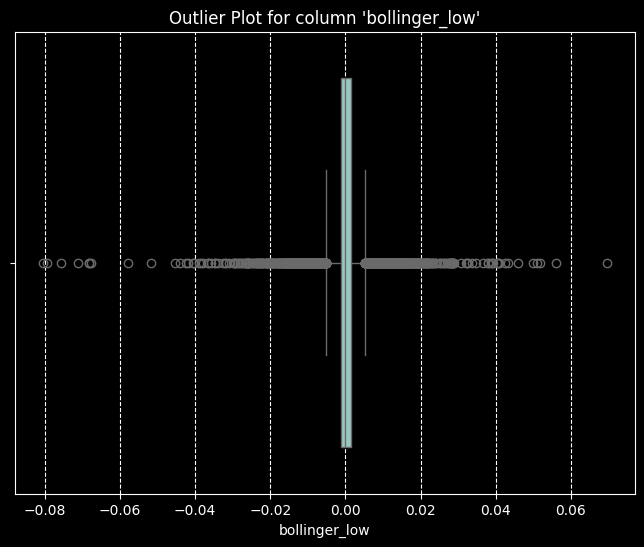

***************************************************************************

Outliers in column 'volume_mean_10':
Outlier Count: 1685
Outlier Percentage of total observations: 6.43%
Outlier Values: 2821339.1, 2956797.5, 3198840.7, 3269142.9, 3278485.0, 3074474.8, 3041331.3, 2847091.8, 2706362.3, 2986218.8, 3251055.3, 3484305.1, 3572977.0, 3594166.6, 3579494.3, 3637847.2, 3722660.1, 2794584.2, 2548719.9, 2616701.6, 2775765.6, 3234741.6, 3512495.4, 3110825.2, 2890985.6, 2891361.5, 2860611.6, 3070772.9, 3761653.0, 3780879.9, 3637428.2, 3246487.6, 3296332.0, 4804446.2, 5838688.4, 7179416.3, 8278046.1, 8561821.8, 8106504.8, 8360807.8, 8483112.2, 8671488.3, 8462096.1, 7134695.8, 7020354.1, 6205315.0, 7004037.1, 8903870.5, 11065532.2, 12931018.3, 13950062.7, 14253471.4, 14294072.7, 14508907.8, 13934161.9, 13643797.5, 12027583.7, 10299036.3, 8064025.4, 6850925.9, 6908916.9, 7527926.3, 11958602.7, 16140810.8, 19766099.5, 21845980.2, 24023968.3, 25635499.1, 27904740.4, 31275208.2, 34112421.3, 35

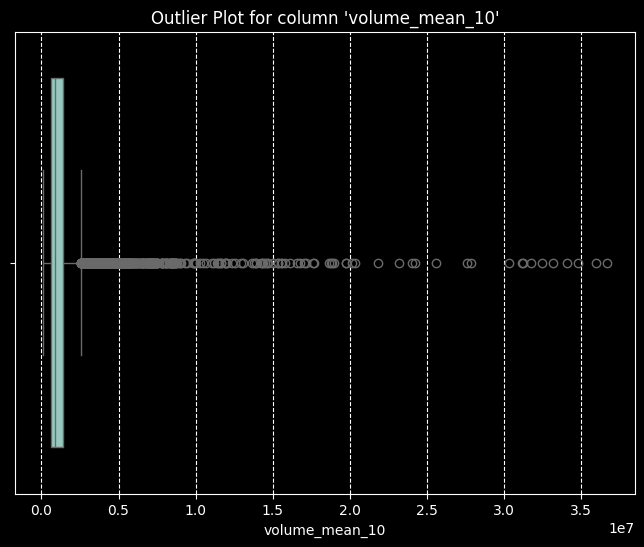

***************************************************************************

Outliers in column 'volume_mean_30':
Outlier Count: 1787
Outlier Percentage of total observations: 6.82%
Outlier Values: 2371553.3666666667, 2388497.5, 2417507.9, 2461269.7666666666, 2464499.2333333334, 2513779.8333333335, 2712447.966666667, 2758009.6666666665, 2775034.1, 2764593.8, 2897081.7, 3419787.1666666665, 3759464.6333333333, 4141160.4, 4494536.966666667, 4649554.766666667, 4772557.766666667, 4919463.1, 4965435.333333333, 5050905.833333333, 5090307.833333333, 5016655.733333333, 5250009.366666666, 5425364.266666667, 6047564.933333334, 6845488.4, 7644563.333333333, 8357568.666666667, 8690201.033333333, 8723815.766666668, 8684166.933333334, 8816016.6, 8931068.133333333, 9009509.6, 9103222.3, 9254909.533333333, 9078687.466666667, 9380917.333333334, 9780697.266666668, 10150962.0, 11571590.5, 12594804.8, 13573538.5, 13898364.233333332, 14351863.033333333, 14946135.3, 15678099.333333334, 17019050.8, 18323800.3

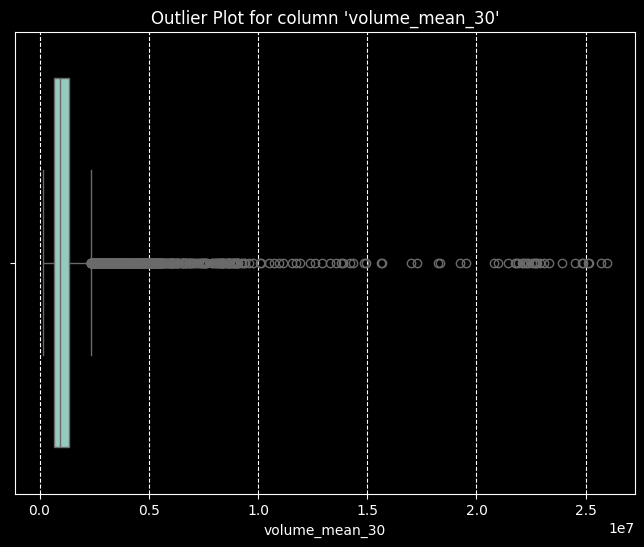

***************************************************************************

Outliers in column 'parabolic_SAR':
Outlier Count: 2937
Outlier Percentage of total observations: 11.21%
Outlier Values: 0.017777409398608057, -0.02757265465123604, 0.03407644013725086, -0.035134741601608344, 0.04466644698557021, -0.03314143464716368, 0.022093565121169778, -0.028028391737140446, 0.03907446047148033, -0.038454539673288046, 0.02925110350362603, -0.028918631638308767, 0.024968526299003813, -0.022154859691127182, 0.02305854042220501, -0.025092188519082903, 0.04287533018501177, -0.0474938036453616, 0.036528046687039684, -0.045052179695609595, 0.043502457528610705, -0.008861152691198804, -0.00948400939787053, -0.013079112939008208, -0.011652847890707196, -0.010368048941436392, -0.009213661105167859, -0.010975556490139482, -0.012144318222409911, -0.01031645439028317, -0.008748835776655639, -0.031422641486232195, 0.021419993106298385, -0.029535272832574844, 0.04091033516943199, -0.045713381735480674, 

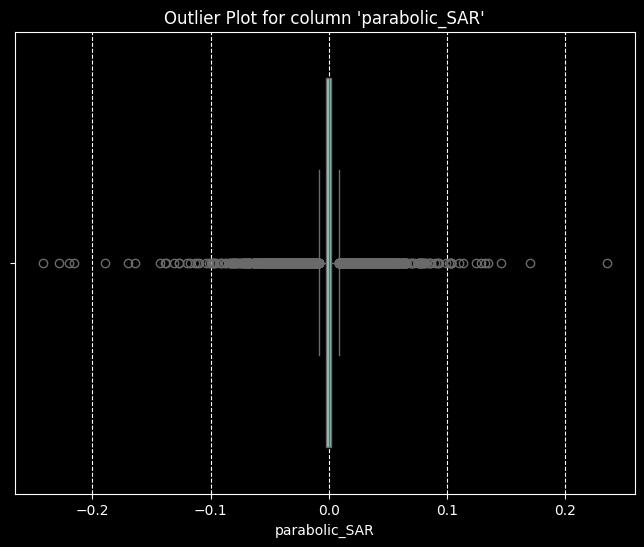

***************************************************************************

Outliers in column 'ADX':
Outlier Count: 500
Outlier Percentage of total observations: 1.91%
Outlier Values: 57.4658423837919, 60.0147957634331, 62.3816810445285, 63.98248161965379, 63.14377615773251, 61.62550077988038, 60.19099368503138, 57.81303597574481, 56.652125316392514, 56.96663820584513, 57.31565795013045, 57.49256633603859, 57.72368445127029, 56.72283303791214, 57.22376358907063, 58.00983998527458, 58.73976806746396, 59.55119092657305, 60.41520012214263, 60.87554642404443, 61.725271573711325, 62.90020492929817, 64.35056251253907, 66.11683151501796, 67.75693844589122, 69.03009517409586, 70.29136636189367, 71.47387279335834, 72.63570586722005, 73.77631472881458, 74.83545152886664, 75.95920591402405, 77.00269212881308, 78.0391446604229, 77.79912645074872, 76.91276305349236, 76.23277207396146, 75.83767985119906, 75.74318697765048, 75.4728483693227, 74.50258485310363, 73.57526563113872, 72.71418349645704, 

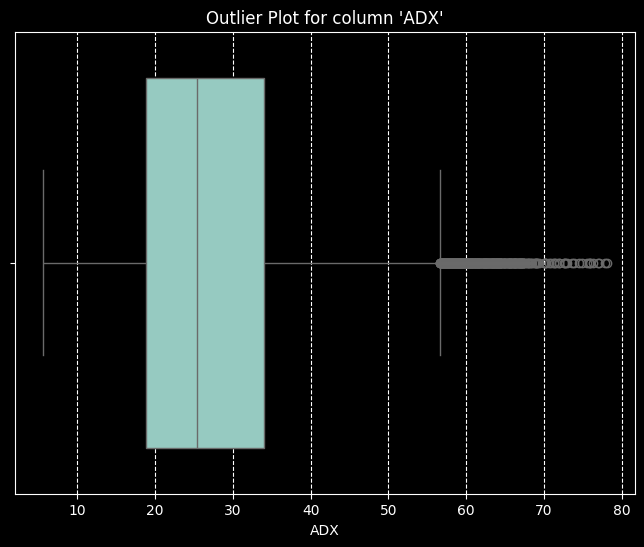

***************************************************************************

Outliers in column 'CCI':
Outlier Count: 52
Outlier Percentage of total observations: 0.20%
Outlier Values: -358.6831744224654, 357.74091627172163, -335.202706369739, 344.61150800242893, 365.59237679048334, -381.1250418650716, 347.9678015307299, -390.43941133493655, -337.30495201083556, 466.66666666666424, 339.56073497587136, -369.10869798946186, -370.54812080192784, -354.1072925398154, -367.9290157336288, -389.05115063812684, -339.64530431277035, -449.00095426851504, -440.6965207406737, -342.2147307588102, -419.06806957268714, -352.6981935335358, -411.9763556926198, -334.6488483656693, -348.50626515072264, -363.5865958858665, 403.69244282287815, 355.6524746613189, 347.56104174293137, 404.28864920388145, 385.6145346078231, -346.6333575181944, -334.82938325699917, -380.08524514933896, -335.21287431249107, -335.6103977914903, -377.1915343216555, -336.5568212122324, -378.4706798033341, 336.1215229828594, 366.6378

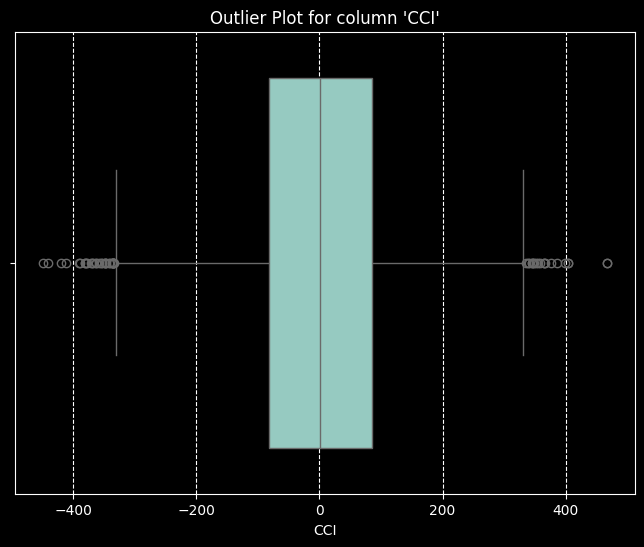

***************************************************************************

No outliers in column 'stochastic_oscillator_k'.
***************************************************************************

No outliers in column 'stochastic_oscillator_d'.
***************************************************************************

Outliers in column 'return':
Outlier Count: 1658
Outlier Percentage of total observations: 6.33%
Outlier Values: 0.031415241057542787, -0.018998793727382224, 0.02519732847601719, -0.059456229459217136, -0.020012706480304954, 0.02160300563556672, 0.020659882824545228, 0.020276226858654045, -0.02053622361665708, 0.041884816753926524, -0.022613065326633208, 0.018678160919540332, 0.03714998613806486, 0.01991388589881593, 0.02242744063324542, -0.06711758584807492, -0.02061265387918687, 0.018873576992210817, 0.02511820330969261, -0.01989045834534442, -0.021629629629629554, -0.019845971563980935, -0.028828270303781767, -0.022554002541296136, -0.02080745341614909, 0.0199

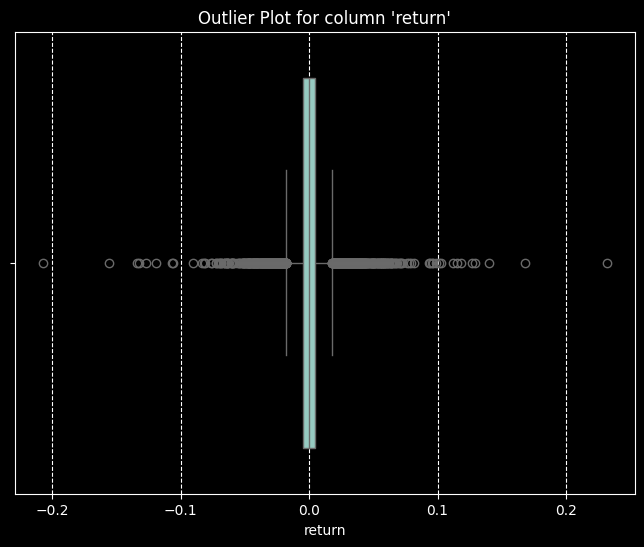

***************************************************************************

Outliers in column 'price_change':
Outlier Count: 1659
Outlier Percentage of total observations: 6.33%
Outlier Values: 0.031415241057542787, -0.018998793727382224, 0.02519732847601719, -0.059456229459217136, -0.020012706480304954, 0.02160300563556672, 0.020659882824545228, 0.020276226858654045, -0.02053622361665708, 0.041884816753926524, -0.022613065326633208, 0.018678160919540332, 0.03714998613806486, 0.01991388589881593, 0.02242744063324542, -0.06711758584807492, -0.02061265387918687, 0.018873576992210817, 0.02511820330969261, -0.01989045834534442, -0.021629629629629554, -0.019845971563980935, -0.028828270303781767, -0.022554002541296136, -0.02080745341614909, 0.019905213270142275, 0.02323420074349447, -0.04571601574326378, -0.027601522842639614, 0.02005640864932623, 0.02857142857142847, 0.024660912453760897, -0.04218795461157976, 0.019661222020568525, 0.024154589371980784, 0.026369762672135977, -0.023355263

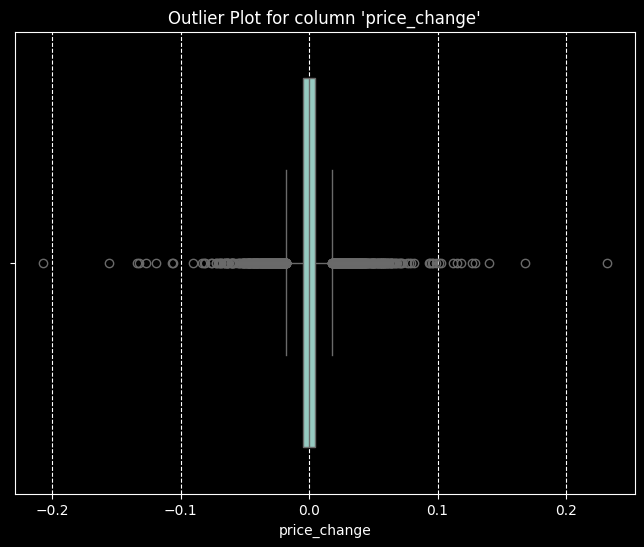

***************************************************************************

Outliers in column 'trade_signal':
Outlier Count: 12134
Outlier Percentage of total observations: 46.31%
Outlier Values: -1, -1, 1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, -1, -1, 1, 1, -1, 1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, 1, 1, 1, 1, -1, -1, -1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1,

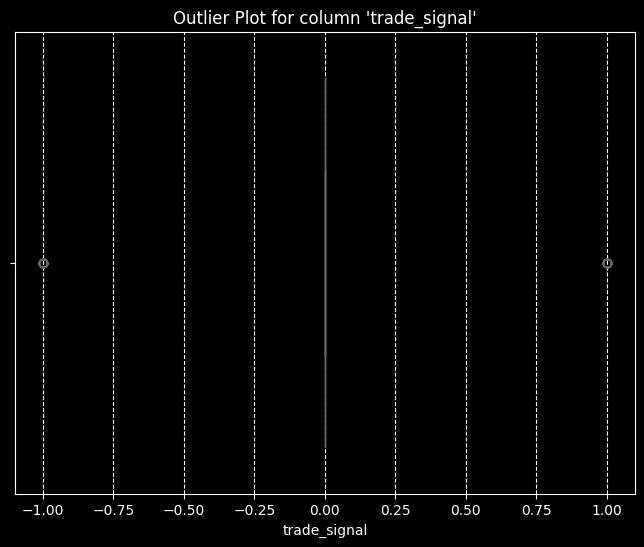

***************************************************************************



Column Outlier Count Outlier Percentage
0                      open          1665           6.354234
1                      high          2077           7.926573
2                       low          2164           8.258596
3                     close          1665           6.354234
4                    volume          2041           7.789184
5                      doji           NaN                NaN
6                    hammer           NaN                NaN
7           inverted_hammer           NaN                NaN
8         bullish_engulfing           NaN                NaN
9         bearish_engulfing           NaN                NaN
10            piercing_line           NaN                NaN
11               dark_cloud           NaN                NaN
12             morning_star           NaN                NaN
13             evening_star           NaN                NaN
14     three_white_soldiers           NaN                NaN
15        three_black_crows           NaN                NaN
16           bearish_harami           NaN                NaN
17                      ATR           483             1.8433
18    historical_volatility          1341           5.117735
19                   SMA_10          1384           5.281838
20                   SMA_30          1190           4.541465
21                   SMA_50          1106           4.220891
22                  SMA_100           900           3.434721
23                  SMA_200           900           3.434721
24                   EMA_10          1750           6.678625
25                   EMA_30          1381           5.270389
26                   EMA_50          1209           4.613975
27                  EMA_100          1044           3.984277
28                  EMA_200           900           3.434721
29                   RSI_14           163           0.622066
30                     MACD          4399          16.788154
31              MACD_signal          4293           16.38362
32           bollinger_high          3119          11.903217
33            bollinger_mid          1092           4.167462
34            bollinger_low          3148          12.013892
35           volume_mean_10          1685           6.430561
36           volume_mean_30          1787            6.81983
37            parabolic_SAR          2937           11.20864
38                      ADX           500           1.908178
39                      CCI            52           0.198451
40  stochastic_oscillator_k             0                  0
41  stochastic_oscillator_d             0                  0
42                   return          1658            6.32752
43             price_change          1659           6.331336
44             trade_signal         12134          46.307675

In [ ]:
 detect_outliers(df_stationary)

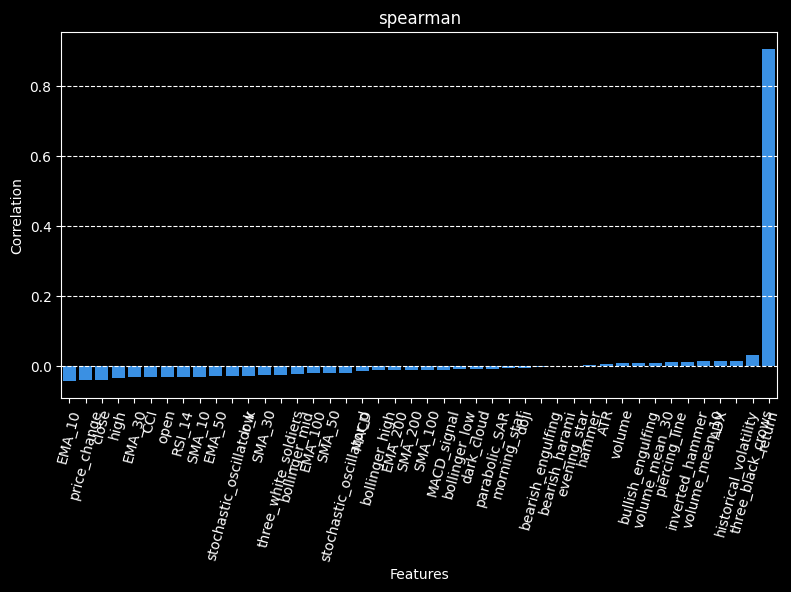

Correlation table with target feature 'trade_signal':


Correlation Type         spearman
Column                           
return                   0.905743
three_black_crows        0.032004
historical_volatility    0.014334
ADX                      0.013316
volume_mean_10           0.013300
inverted_hammer          0.012217
piercing_line            0.010606
volume_mean_30           0.008587
bullish_engulfing        0.007843
volume                   0.007747
ATR                      0.006283
hammer                   0.004629
evening_star             0.000580
bearish_harami          -0.000144
bearish_engulfing       -0.002484
doji                    -0.004326
morning_star            -0.004857
parabolic_SAR           -0.008692
dark_cloud              -0.009119
bollinger_low           -0.009131
MACD_signal             -0.011226
EMA_200                 -0.011913
SMA_200                 -0.011913
SMA_100                 -0.011913
bollinger_high          -0.012439
MACD                    -0.014803
stochastic_oscillator_d -0.018614
SMA_50                  -0.020324
EMA_100                 -0.020583
bollinger_mid           -0.022610
three_white_soldiers    -0.024463
SMA_30                  -0.025889
low                     -0.026766
stochastic_oscillator_k -0.027283
EMA_50                  -0.027757
SMA_10                  -0.030154
RSI_14                  -0.030412
open                    -0.030593
CCI                     -0.031217
EMA_30                  -0.032394
high                    -0.033779
close                   -0.038882
price_change            -0.038882
EMA_10                  -0.043544


Top 2 features with highest correlation (Spearman): ['return', 'EMA_10']


In [ ]:
correlation_analysis(df_stationary, 'trade_signal', correlation_types=['spearman'])

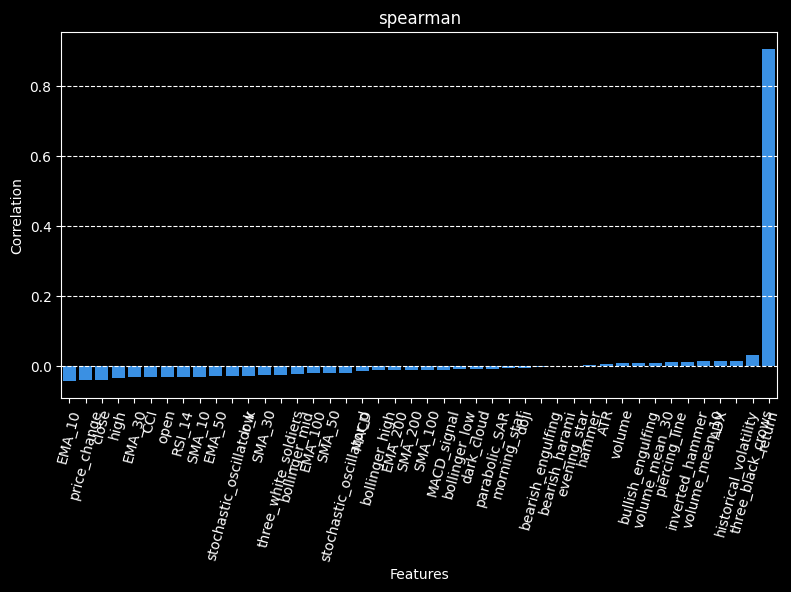

Correlation table with target feature 'trade_signal':


Correlation Type         spearman
Column                           
return                   0.905743
three_black_crows        0.032004
historical_volatility    0.014334
ADX                      0.013316
volume_mean_10           0.013300
inverted_hammer          0.012217
piercing_line            0.010606
volume_mean_30           0.008587
bullish_engulfing        0.007843
volume                   0.007747
ATR                      0.006283
hammer                   0.004629
evening_star             0.000580
bearish_harami          -0.000144
bearish_engulfing       -0.002484
doji                    -0.004326
morning_star            -0.004857
parabolic_SAR           -0.008692
dark_cloud              -0.009119
bollinger_low           -0.009131
MACD_signal             -0.011226
EMA_200                 -0.011913
SMA_200                 -0.011913
SMA_100                 -0.011913
bollinger_high          -0.012439
MACD                    -0.014803
stochastic_oscillator_d -0.018614
SMA_50                  -0.020324
EMA_100                 -0.020583
bollinger_mid           -0.022610
three_white_soldiers    -0.024463
SMA_30                  -0.025889
low                     -0.026766
stochastic_oscillator_k -0.027283
EMA_50                  -0.027757
SMA_10                  -0.030154
RSI_14                  -0.030412
open                    -0.030593
CCI                     -0.031217
EMA_30                  -0.032394
high                    -0.033779
close                   -0.038882
price_change            -0.038882
EMA_10                  -0.043544


Top 2 features with highest correlation (Spearman): ['return', 'EMA_10']


In [ ]:
correlation_analysis(df_stationary, 'trade_signal', correlation_types=['spearman'])

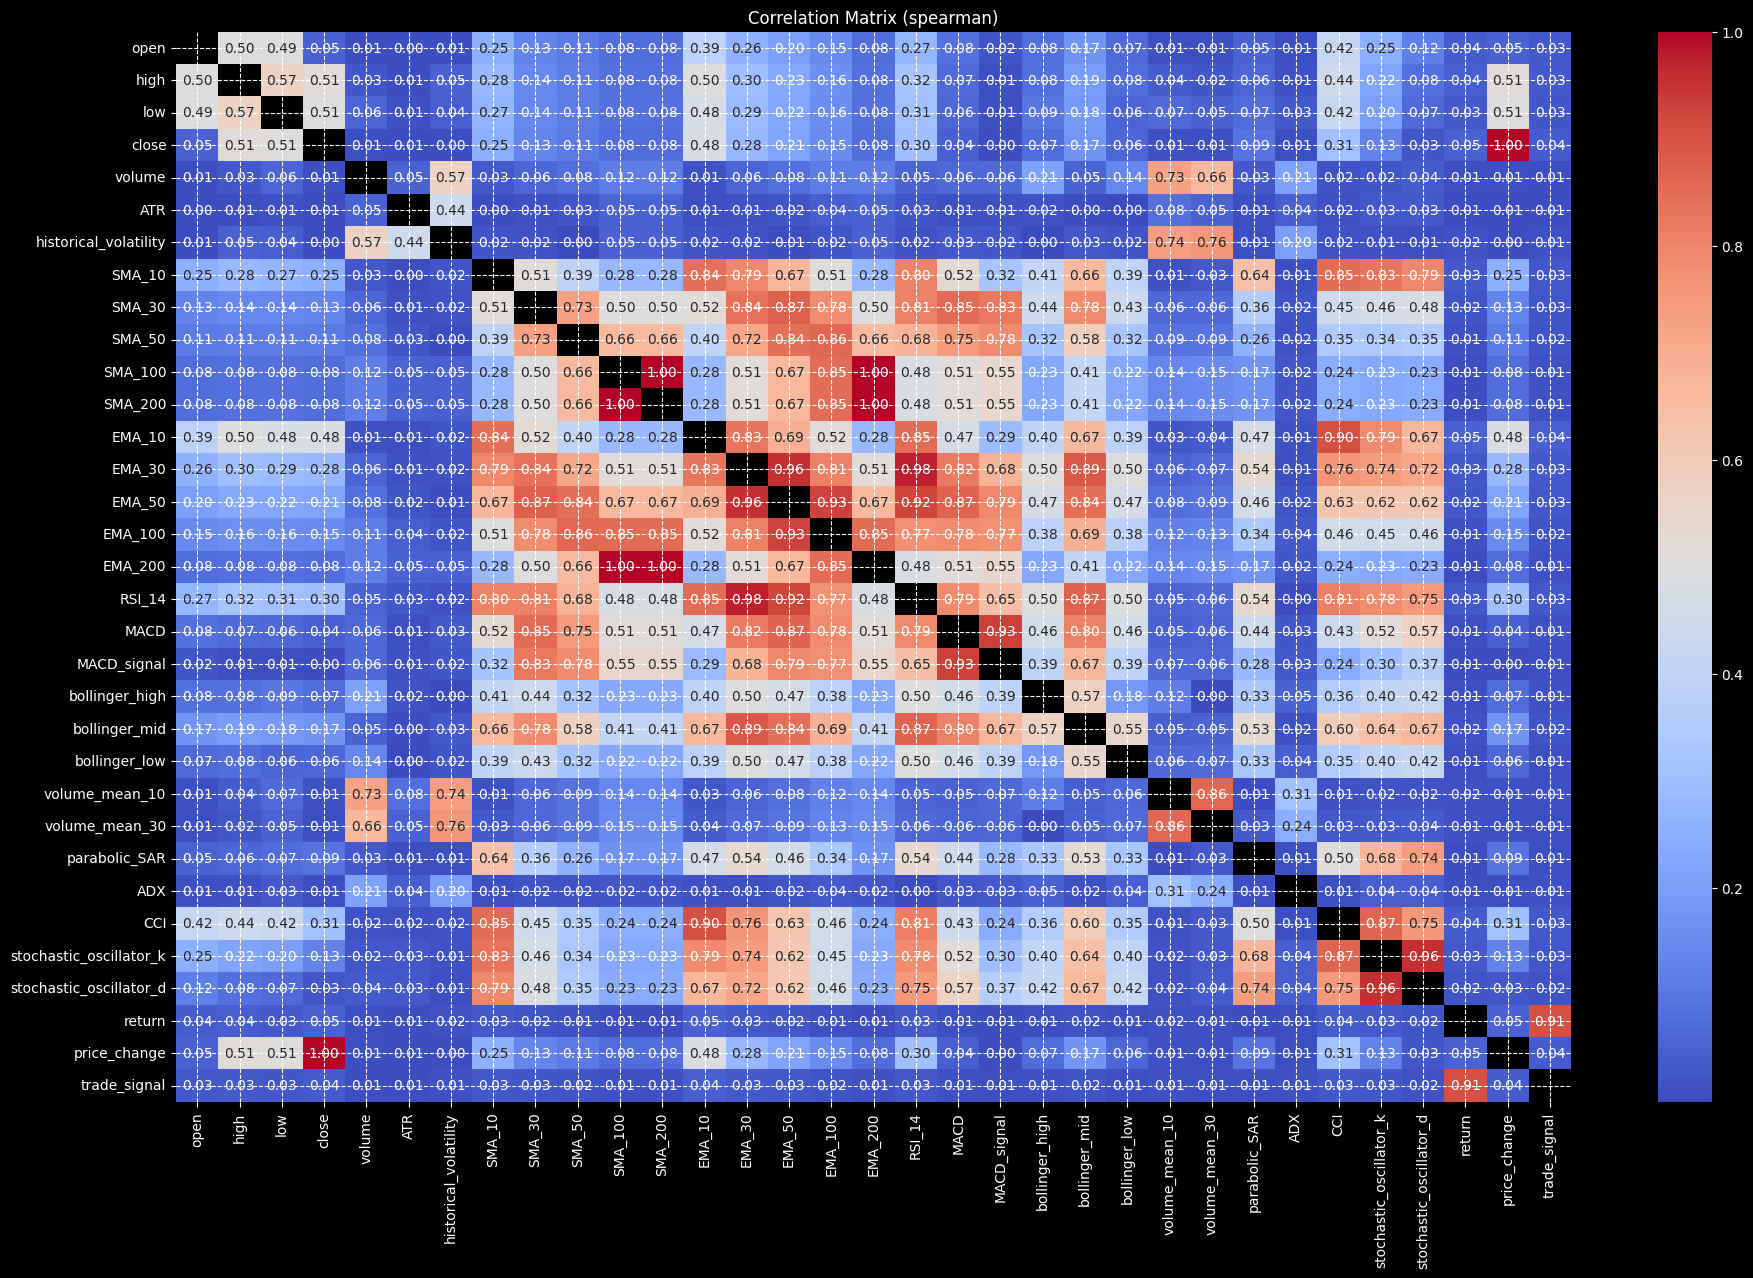


Multicollinearity Table (spearman)


Feature 1                Feature 2  Correlation
1                   SMA_100                  SMA_200     1.000000
2                   SMA_100                  EMA_200     1.000000
3                   SMA_200                  EMA_200     1.000000
0                     close             price_change     1.000000
6                    EMA_30                   RSI_14     0.975846
5                    EMA_30                   EMA_50     0.957009
10  stochastic_oscillator_k  stochastic_oscillator_d     0.956267
9                      MACD              MACD_signal     0.930870
7                    EMA_50                  EMA_100     0.926681
8                    EMA_50                   RSI_14     0.923588
11                   return             trade_signal     0.905743
4                    EMA_10                      CCI     0.904533

In [ ]:
find_multicollinearity(df_stationary, methods=['spearman'], threshold=0.9)

## Data splitting

In [ ]:
df = df_stationary.copy()

In [ ]:
df.dropna(inplace=True)
df.info()

In [ ]:
df.columns

In [ ]:
# Split Target from Featureset

# X = df.iloc[:, :-1] # all rows and all columns are selected except the last column ["TARGET"].
# y = df.iloc[:, -1] # select the last column ["TARGET"]


# X = df.drop(columns=["trade_signal", "return", "SMA_200", "EMA_200", "price_change", "EMA_50", "stochastic_oscillator_d", "MACD_signal"])

X = df.drop(columns=['three_black_crows', 'harami_cross',
       'bearish_harami', 'ATR', 'historical_volatility', 'SMA_10', 'SMA_30',
       'SMA_50', 'SMA_100', 'SMA_200', 'EMA_10', 'EMA_30', 'EMA_50', 'EMA_100',
       'EMA_200', 'RSI_14', 'MACD', 'MACD_signal', 'bollinger_high',
       'bollinger_mid', 'bollinger_low', 'volume_mean_10', 'volume_mean_30',
       'parabolic_SAR', 'ADX', 'CCI', 'stochastic_oscillator_k',
       'stochastic_oscillator_d', 'return', 'price_change', 'trade_signal'])

y = df["trade_signal"]

X = X.astype({col: int for col in X.select_dtypes(include=bool).columns})

In [ ]:
# split time series: train 80%, test 20%

train_size = int(len(X) * 0.8)

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Train start:", X_train.index.min())
print("Train end:  ", X_train.index.max())
print("Test start: ", X_test.index.min())
print("Test end:   ", X_test.index.max())

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled

In [ ]:
print("Train shape:", X_train_scaled.shape, y_train.shape)
print("Test shape:", X_test_scaled.shape, y_test.shape)

In [ ]:
X_train_scaled

## Train and evaluation

In [ ]:
from sklearn.utils import compute_class_weight
import numpy as np

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
weights_dict = dict(zip(classes, class_weights))

In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix

# Перекодируем: -1 -> 0, 0 -> 1, 1 -> 2
y_train_enc = np.where(y_train == -1, 0,
                       np.where(y_train == 0, 1, 2))
y_test_enc = np.where(y_test == -1, 0,
                      np.where(y_test == 0, 1, 2))

model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    random_state=42,

    # ключевые ограничения
    max_depth=3,          # глубина деревьев (3–6 нормально)
    min_child_weight=5,   # минимальное число выборок в листе
    subsample=0.7,        # доля выборки для каждого дерева
    colsample_bytree=0.7, # доля признаков для каждого дерева

    # регуляризация
    reg_alpha=0.1,        # L1
    reg_lambda=1.0,       # L2

    n_estimators=500,     # количество деревьев (побольше)
    learning_rate=0.05    # и поменьше шаг обучения
)


sample_weights = y_train.map(weights_dict)

model.fit(X_train, y_train_enc, sample_weight=sample_weights)

y_train_pred_enc = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)

y_train_pred = np.where(y_train_pred_enc == 0, -1,
                        np.where(y_train_pred_enc == 1, 0, 1))

# Предсказания
y_pred_enc = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

# Обратно в исходные классы (-1, 0, 1)
y_pred = np.where(y_pred_enc == 0, -1,
                  np.where(y_pred_enc == 1, 0, 1))



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# --- Accuracy ---
print("Train accuracy:", accuracy_score(y_train_enc, model.predict(X_train)))
print("Test accuracy:", accuracy_score(y_test_enc, model.predict(X_test)))


# --- Classification report ---
print("\nClassification Report (Train):")
print(classification_report(y_train, y_train_pred))  # здесь используем исходные классы [-1,0,1]


# --- Classification report ---
print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred))  # здесь используем исходные классы [-1,0,1]

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred, labels=[-1,0,1])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Short (-1)", "Hold (0)", "Long (1)"],
            yticklabels=["Short (-1)", "Hold (0)", "Long (1)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## Backtest

In [ ]:
! pip install backtrader
import backtrader as bt

In [ ]:
# Creating a Dataframe with test data and predictions

test_data = data.loc[X_test.index].copy()
test_data['predictions'] = y_pred

# Converting data to backtrader format
class CustomPandasData(bt.feeds.PandasData):
    lines = ('predictions',)
    params = (
        ('predictions', -1),
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('openinterest', None),
    )

In [ ]:
class MLStrategy(bt.Strategy):
    params = (
        ('stop_loss', 0.01), # 1% stop loss
        ('take_profit', 0.1), # 10% take profit
        ('stake', 1000) # position size in dollars
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.predictions = self.datas[0].predictions
        self.order = None # checking for existing order
        self.price = None
        self.stop_price = None
        self.take_profit_price = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return # orders sent / accepted by broker

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f"BUY EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
                self.price = order.executed.price
                self.stop_price = self.price * (1.0 - self.params.stop_loss)
                self.take_profit_price = self.price * (1.0 + self.params.take_profit)
            elif order.issell():
                self.log(f"SELL EXECUTED, Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f}, Comm: {order.executed.comm:.2f}")
            self.order = None

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION PROFIT, GROSS {trade.pnl:.2f}, NET {trade.pnlcomm:.2f}')

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} {txt}')

    def next(self):
        if self.order:
            return

        if not self.position:
            if self.predictions[0] > 0:
                self.order = self.buy(size=self.params.stake / self.dataclose[0])
                self.log(f'BUY CREATED, Price: {self.dataclose[0]:.2f}')

        else:
            if self.dataclose[0] <= self.stop_price or self.dataclose[0] >= self.take_profit_price:
                self.order = self.sell(size=self.position.size)
                self.log(f'SELL CREATED, Price: {self.dataclose[0]:.2f}')

        # Output current portfolio value for debugging
        self.log(f'Position Value: {self.broker.getvalue():.2f}')

In [ ]:
# Create Cerebro and add data and strategy
cerebro = bt.Cerebro()
cerebro.addstrategy(MLStrategy)


# Convert data to backtrader format
datafeed = CustomPandasData(dataname=test_data)
cerebro.adddata(datafeed)

# Add Observer to track profile cost
cerebro.addobserver(bt.observers.Value)

# Initial funds
cerebro.broker.set_cash(10000.0)

# Set Commision
cerebro.broker.setcommission(commission=0.001)


# Run backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
strategies = cerebro.run()
print('Ending Portfolio Value: %.2f' % cerebro.broker.getvalue())

# Getting profile values ​​and dates from Observer
portfolio_values = [ob for ob in strategies[0].observers if isinstance(ob, bt.observers.Value)][0].lines.value.get(0, size=len(test_data))
portfolio_dates = test_data.index[:len(portfolio_values)]

Streaming output truncated to the last 5000 lines.
2025-05-29 Position Value: 9437.26
2025-05-29 Position Value: 9440.14
2025-05-29 Position Value: 9444.09
2025-05-29 Position Value: 9441.62
2025-05-29 Position Value: 9440.14
2025-05-29 Position Value: 9435.50
2025-05-29 Position Value: 9435.32
2025-05-29 Position Value: 9429.32
2025-05-29 Position Value: 9421.55
2025-05-29 Position Value: 9428.67
2025-05-29 Position Value: 9427.73
2025-05-29 Position Value: 9423.20
2025-05-29 Position Value: 9421.84
2025-05-29 Position Value: 9415.08
2025-05-29 SELL CREATED, Price: 168.24
2025-05-29 Position Value: 9414.90
2025-05-29 SELL EXECUTED, Price: 168.23, Cost: 1000.00, Comm: 0.99
2025-05-29 OPERATION PROFIT, GROSS -10.06, NET -12.05
2025-05-29 Position Value: 9413.85
2025-05-29 Position Value: 9413.85
2025-05-29 BUY CREATED, Price: 167.77
2025-05-29 Position Value: 9413.85
2025-05-29 BUY EXECUTED, Price: 167.78, Cost: 1000.06, Comm: 1.00
2025-05-29 Position Value: 9406.12
2025-05-29 Position 

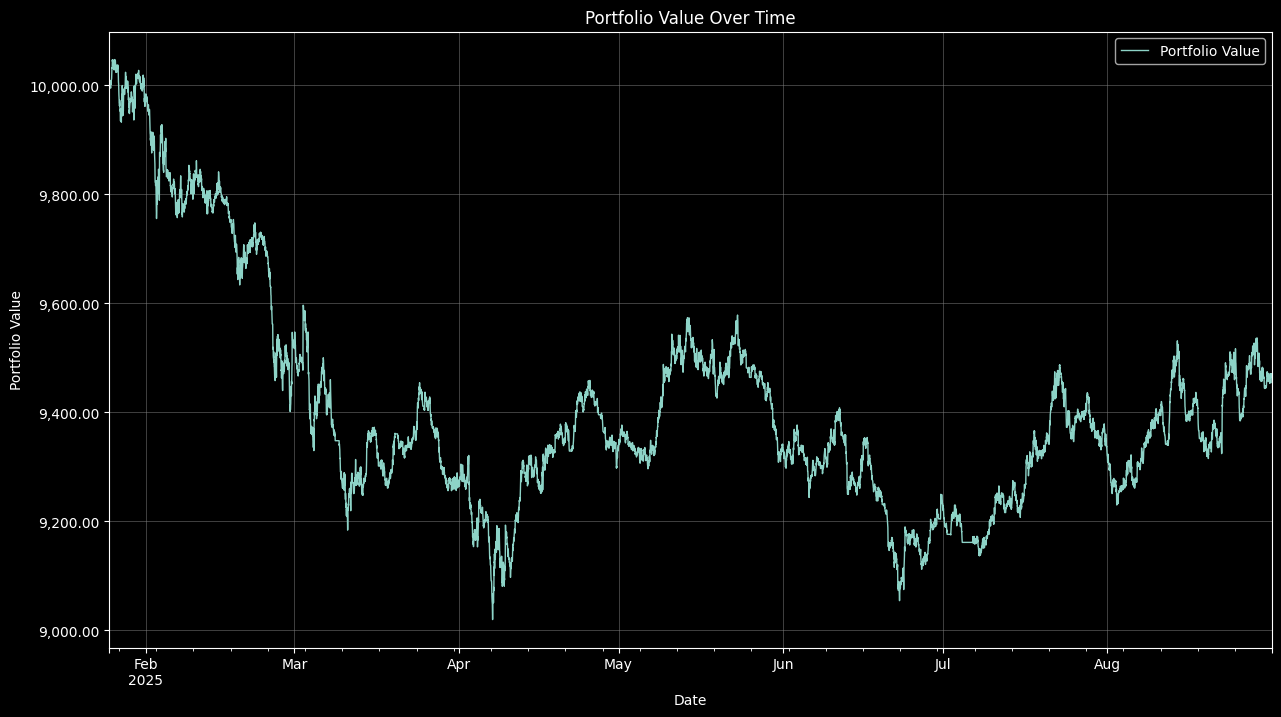

In [ ]:
# Creating a Dataframe with portfolio values and predictions

portfolio_df = pd.DataFrame({'Date': portfolio_dates, 'portfolio_value': portfolio_values})
portfolio_df.set_index('Date', inplace=True)

%matplotlib inline
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(15, 8))
portfolio_df['portfolio_value'].plot(label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.grid(color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.2f}'.format(x)))
plt.legend()
plt.show()

## Log profobility

log_return = log(close t+1 / close t) - логорифм от часовой доходности 4:30